## Imports

In [97]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import plotnine as p9
import statsmodels.formula.api as smf

import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Load Yahoo Data

We will be getting Dividend Adjusted data -> which could be the difference between Yahoo and TradingView data

In [98]:
# tickers = ['SPY', 'TLT']
# ydata = yf.Tickers(tickers).download(period="max", auto_adjust=True)   # get dividend adjusted prices

Convert Yahoo Data to long-format

In [99]:
# data = (   # put data in long form
#     ydata
#     .dropna()
#     .stack(1, future_stack=True)
#     .reset_index()
#     [['Date', 'Ticker', 'Close']]
#     .sort_values(by=['Date', 'Ticker'])
# )

# data.head(5)

In [100]:
# # download historical data from Yahoo Finance to csv, file name data_<tickers>_2002-07-30_D.csv
# data.to_csv('data_SPY_TLT_2002-07-30_D.csv', index=False)

## Create return data for the various periods of Month defined by (N, M)

In [101]:
# read data from csv
data = pd.read_csv('data_SPY_TLT_2002-07-30_D.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11710 entries, 0 to 11709
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    11710 non-null  datetime64[ns]
 1   Ticker  11710 non-null  object        
 2   Close   11710 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 274.6+ KB
None
        Date Ticker      Close
0 2002-07-30    SPY  59.177742
1 2002-07-30    TLT  36.922298
2 2002-07-31    SPY  59.320900
3 2002-07-31    TLT  37.379738
4 2002-08-01    SPY  57.772137


In [102]:
# Add year-month label (end of month date)

# Convert Date column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'ym' representing the last day of each month
data['ym'] = data['Date'] + pd.offsets.MonthEnd(0)

data.head()

,Date,Ticker,Close,ym
0,2002-07-30,SPY,59.177742,2002-07-31
1,2002-07-30,TLT,36.922298,2002-07-31
2,2002-07-31,SPY,59.320900,2002-07-31
3,2002-07-31,TLT,37.379738,2002-07-31
4,2002-08-01,SPY,57.772137,2002-08-31


In [103]:
# Create trading-day counter for each Ticker and month

# Sort data to ensure correct order
data = data.sort_values(['Ticker', 'Date']).copy()

# Count trading days within each (Ticker, ym) group
data['td'] = data.groupby(['Ticker', 'ym']).cumcount() + 1

data.head()

,Date,Ticker,Close,ym,td
0,2002-07-30,SPY,59.177742,2002-07-31,1
2,2002-07-31,SPY,59.320900,2002-07-31,2
4,2002-08-01,SPY,57.772137,2002-08-31,1
6,2002-08-02,SPY,56.477192,2002-08-31,2
8,2002-08-05,SPY,54.511971,2002-08-31,3


In [104]:
#  Calculate daily simple returns

# Calculate percentage change of 'Close' within each ticker
data['ret'] = data.groupby('Ticker')['Close'].pct_change()

data.head()

,Date,Ticker,Close,ym,td,ret
0,2002-07-30,SPY,59.177742,2002-07-31,1,NaN
2,2002-07-31,SPY,59.320900,2002-07-31,2,0.002419
4,2002-08-01,SPY,57.772137,2002-08-31,1,-0.026108
6,2002-08-02,SPY,56.477192,2002-08-31,2,-0.022415
8,2002-08-05,SPY,54.511971,2002-08-31,3,-0.034797


In [105]:
# # unique Tickers
# tickers = data['Ticker'].unique()
# tickers

In [106]:
# data.tail()

In [107]:
# Filter dates and keep only needed columns

# Keep data from August 2002 onwards
data = data[data['Date'] >= pd.Timestamp(2002, 8, 1)]

# Keep only useful columns
data = data[['Date', 'ym', 'Ticker', 'Close', 'ret', 'td']]

data.head()

,Date,ym,Ticker,Close,ret,td
4,2002-08-01,2002-08-31,SPY,57.772137,-0.026108,1
6,2002-08-02,2002-08-31,SPY,56.477192,-0.022415,2
8,2002-08-05,2002-08-31,SPY,54.511971,-0.034797,3
10,2002-08-06,2002-08-31,SPY,56.347046,0.033664,4
12,2002-08-07,2002-08-31,SPY,57.329628,0.017438,5


In [108]:
# Create start/end/month flags and conditional returns

N = 15  # number of days for start of month
M = 5   # number of days for next start of month

# Flags: 1 if condition true, 0 otherwise
data['som_flag'] = (data['td'] <= N).astype(int)
data['eom_flag'] = (data['td'] > N).astype(int)
data['nsm_flag'] = (data['td'] <= M).astype(int)

# Conditional returns (return only within flag period)
data['ret_som'] = data['ret'] * data['som_flag']
data['ret_eom'] = data['ret'] * data['eom_flag']
data['ret_nsm'] = data['ret'] * data['nsm_flag']

data.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
4,2002-08-01,2002-08-31,SPY,57.772137,-0.026108,1,1,0,1,-0.026108,-0.0,-0.026108
6,2002-08-02,2002-08-31,SPY,56.477192,-0.022415,2,1,0,1,-0.022415,-0.0,-0.022415
8,2002-08-05,2002-08-31,SPY,54.511971,-0.034797,3,1,0,1,-0.034797,-0.0,-0.034797
10,2002-08-06,2002-08-31,SPY,56.347046,0.033664,4,1,0,1,0.033664,0.0,0.033664
12,2002-08-07,2002-08-31,SPY,57.329628,0.017438,5,1,0,1,0.017438,0.0,0.017438


In [109]:
# # check data integrity
# """
# Ticker SPY
# eom_flag 1
# ym 2002-08-31
# print(ret_eom)
# """
# check = data[(data['Ticker'] == 'SPY') & (data['eom_flag'] == 1) & (data['ym'] == pd.Timestamp(2002, 8, 31))]
# print('Dataset check:')
# print(check)

# # print cumulative return for ret_eom
# check_ret_eom = check['ret_eom'].sum()
# print('Cumulative return for ret_eom:')
# print(check_ret_eom)    

In [110]:
# Keep only relevant return columns
data_flags = data[['Date', 'ym', 'Ticker', 'ret_som', 'ret_eom', 'ret_nsm']]

data_flags.head()

,Date,ym,Ticker,ret_som,ret_eom,ret_nsm
4,2002-08-01,2002-08-31,SPY,-0.026108,-0.0,-0.026108
6,2002-08-02,2002-08-31,SPY,-0.022415,-0.0,-0.022415
8,2002-08-05,2002-08-31,SPY,-0.034797,-0.0,-0.034797
10,2002-08-06,2002-08-31,SPY,0.033664,0.0,0.033664
12,2002-08-07,2002-08-31,SPY,0.017438,0.0,0.017438


In [111]:
# Pivot to wide format (one column per Ticker)

# Create wide format table: columns for each Ticker and return type
pivoted = data_flags.pivot(index=['Date', 'ym'], columns='Ticker')

# Flatten multi-level column names (e.g. ret_som_SPY)
pivoted.columns = [f"{col[1]}_{col[0]}" for col in pivoted.columns]

pivoted = pivoted.reset_index()

pivoted.head()

,Date,ym,SPY_ret_som,TLT_ret_som,SPY_ret_eom,TLT_ret_eom,SPY_ret_nsm,TLT_ret_nsm
0,2002-08-01,2002-08-31,-0.026108,0.005696,-0.0,0.0,-0.026108,0.005696
1,2002-08-02,2002-08-31,-0.022415,0.010241,-0.0,0.0,-0.022415,0.010241
2,2002-08-05,2002-08-31,-0.034797,0.004413,-0.0,0.0,-0.034797,0.004413
3,2002-08-06,2002-08-31,0.033664,-0.008549,0.0,-0.0,0.033664,-0.008549
4,2002-08-07,2002-08-31,0.017438,0.002395,0.0,0.0,0.017438,0.002395


In [112]:
# pivoted.head(35)

In [113]:
# create a copy of data to be later used for the backtest analysis (8 PL streams in the backtesting)
backtest_data = pivoted.copy()

In [114]:
# # check data integrity 
# """
# df: pivoted
# col: SPY_ret_eom
# Date: 2002-08-31
# """
# # Option 1: Find the last trading day of August 2002
# august_2002_data = pivoted[pivoted['ym'] == pd.Timestamp(2002, 8, 31)]
# last_trading_day = august_2002_data['Date'].max()

# print(f'Last trading day in August 2002: {last_trading_day}')
# print('Last day data:')
# check = pivoted[pivoted['Date'] == last_trading_day]
# print(check.head())
# print('SPY_ret_eom value:')
# print(check['SPY_ret_eom'].values)

In [115]:
# # Option 2: Check for a trading day that we know exists (like 2002-08-01)
# check = pivoted[pivoted['Date'] == pd.Timestamp(2002, 8, 1)]
# print('Pivoted dataset check (Aug 1, 2002):')
# print(check.head())
# print('SPY_ret_eom value:')
# print(check['SPY_ret_eom'].values)

In [116]:
# # Option 3: Check all August 2002 data where SPY_ret_eom is non-zero
# august_2002 = pivoted[
#     (pivoted['ym'] == pd.Timestamp(2002, 8, 31)) & 
#     (pivoted['SPY_ret_eom'] != 0)
# ]
# print('August 2002 data with non-zero SPY_ret_eom:')
# print(august_2002[['Date', 'SPY_ret_eom', 'TLT_ret_eom']])

In [117]:
# Compute relative returns and aggregate monthly

# Calculate combined and relative returns
pivoted['SPY_ret'] = pivoted['SPY_ret_som'] + pivoted['SPY_ret_eom']
pivoted['SPY_TLT_som'] = pivoted['SPY_ret_som'] - pivoted['TLT_ret_som']
pivoted['SPY_TLT_eom'] = pivoted['SPY_ret_eom'] - pivoted['TLT_ret_eom']
pivoted['SPY_TLT_nsm'] = pivoted['SPY_ret_nsm'] - pivoted['TLT_ret_nsm']

# Select relevant columns
returns = pivoted[['ym', 'SPY_ret', 'SPY_TLT_som', 'SPY_TLT_eom', 'SPY_TLT_nsm']]

# Aggregate monthly returns using compounding formula
monthly = returns.groupby('ym').apply(lambda x: (1 + x).prod() - 1)

monthly.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm
ym,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048050
2002-09-30,-0.104852,-0.120565,-0.026590,-0.020469
2002-10-31,0.082284,0.169239,-0.043636,-0.029224
2002-11-30,0.061680,0.062209,0.003899,0.007640
2002-12-31,-0.056570,-0.062908,-0.037998,-0.032310


In [118]:
monthly.tail(5)

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm
ym,,,,
2025-07-31,0.023032,0.033781,0.000007,0.025906
2025-08-31,0.020520,0.006702,0.012749,-0.012571
2025-09-30,0.035620,0.007519,-0.008637,-0.033473
2025-10-31,0.023837,-0.025525,0.035127,0.002909
2025-11-30,0.001877,0.004378,0.000000,0.004378


In [119]:
return_data = monthly.copy()

## Relation between SOM and EOM relative returns

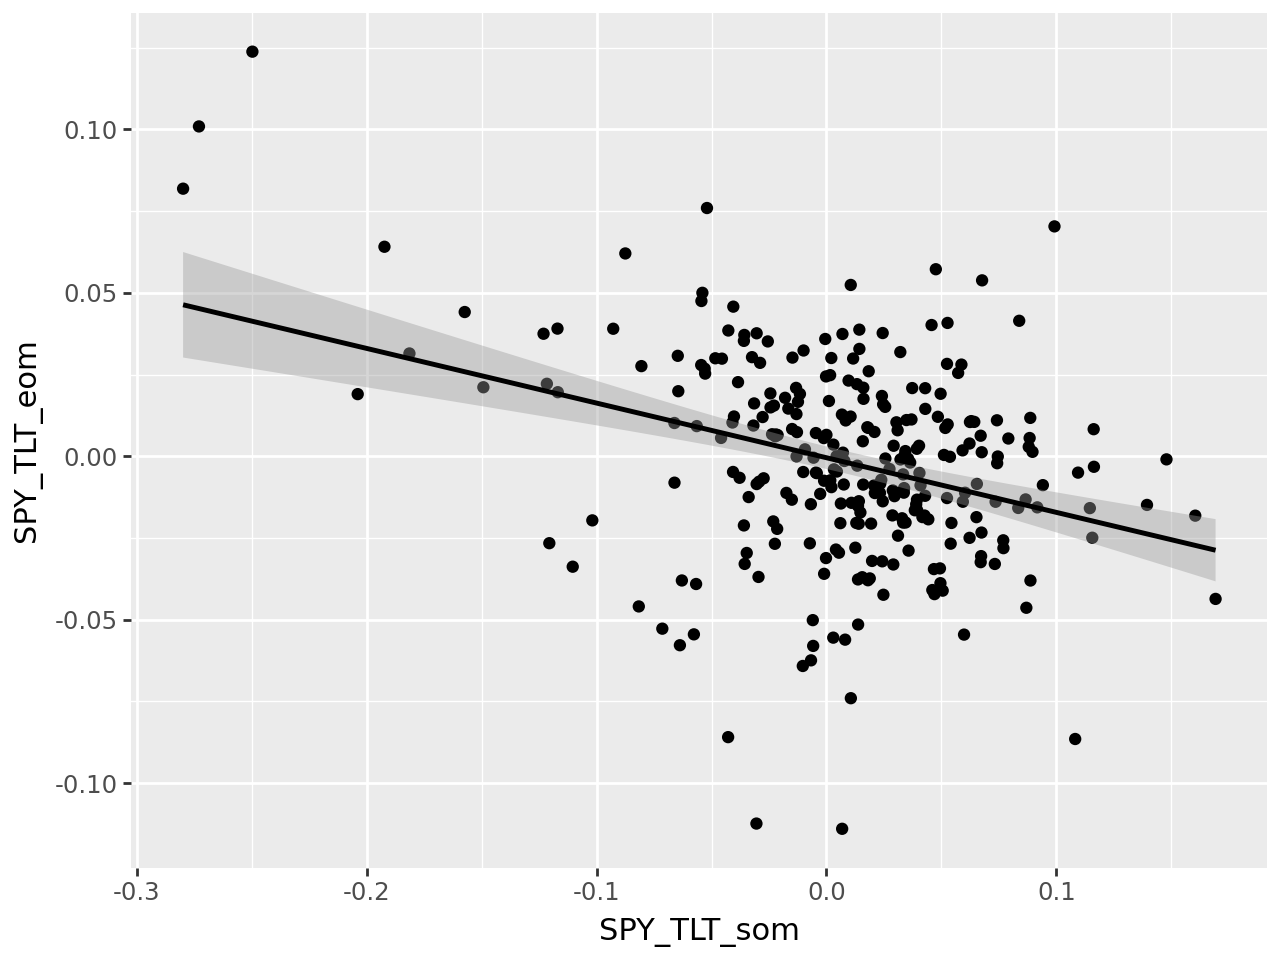

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_eom   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     35.95
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           6.28e-09
Time:                        19:06:44   Log-Likelihood:                 594.03
No. Observations:                 280   AIC:                            -1184.
Df Residuals:                     278   BIC:                            -1177.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0005      0.002     -0.258      

In [120]:
# plot using plotnine
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_som', y='SPY_TLT_eom')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()                                                           # have to explicitly call show otherwise only get print statement below

mod = smf.ols('SPY_TLT_eom ~ SPY_TLT_som', return_data)
res = mod.fit()
print(res.summary())

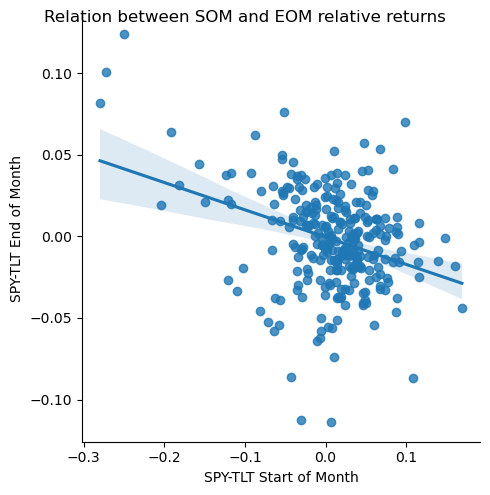

In [121]:
# plot using seaborn with customization
g = sns.lmplot(x='SPY_TLT_som', y='SPY_TLT_eom', data=return_data)
g.set_axis_labels('SPY-TLT Start of Month', 'SPY-TLT End of Month')
g.fig.suptitle('Relation between SOM and EOM relative returns')
plt.show()

## Relationship between EOM and Next SOM

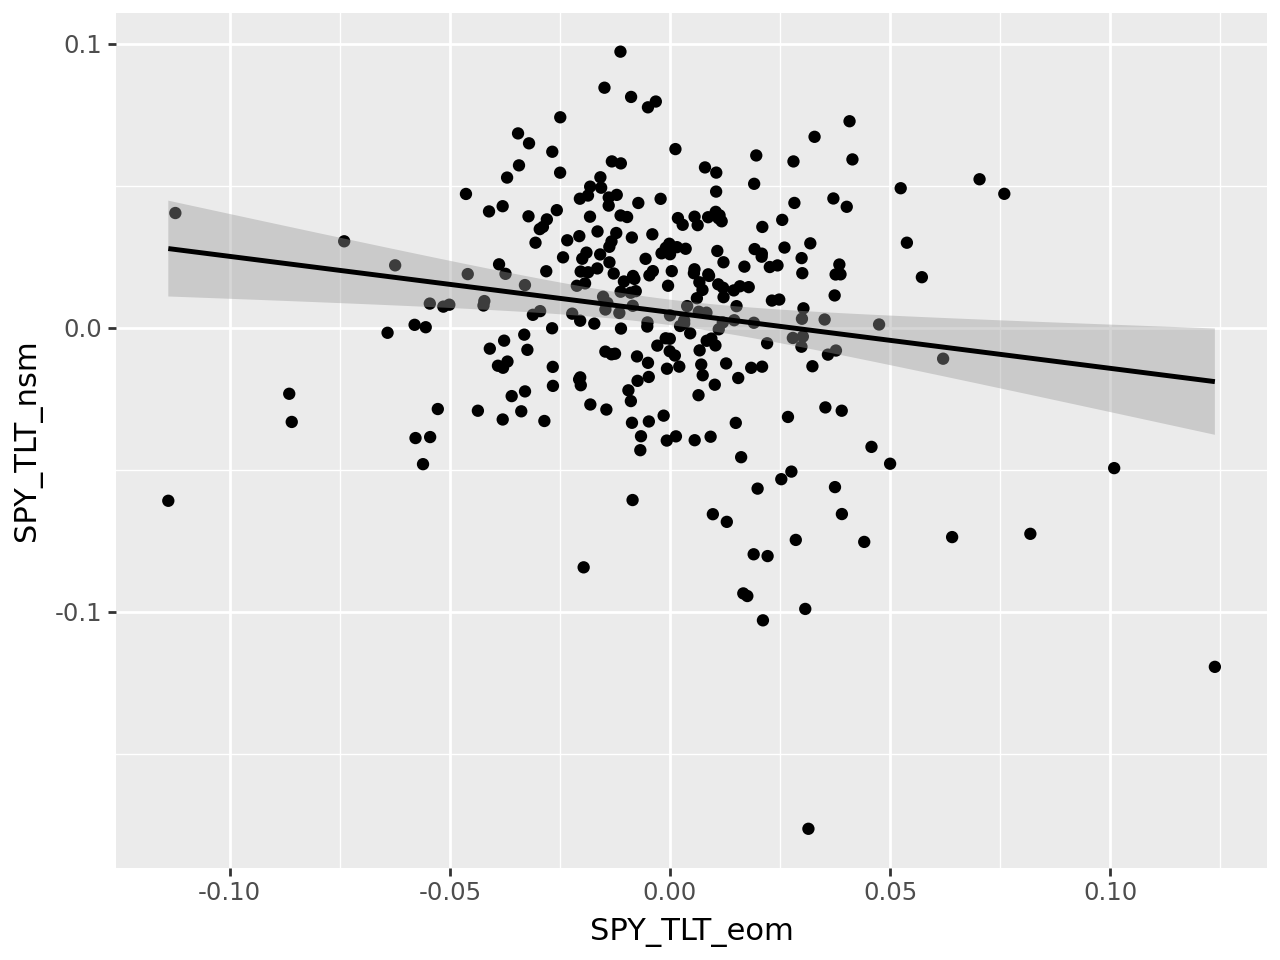

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_nsm   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.168
Date:                Tue, 04 Nov 2025   Prob (F-statistic):            0.00786
Time:                        19:06:45   Log-Likelihood:                 519.48
No. Observations:                 280   AIC:                            -1035.
Df Residuals:                     278   BIC:                            -1028.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0054      0.002      2.390      

In [122]:
# plot using pilotnine
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_eom', y='SPY_TLT_nsm')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()

mod = smf.ols('SPY_TLT_nsm ~ SPY_TLT_eom', return_data)
res = mod.fit()
print(res.summary())

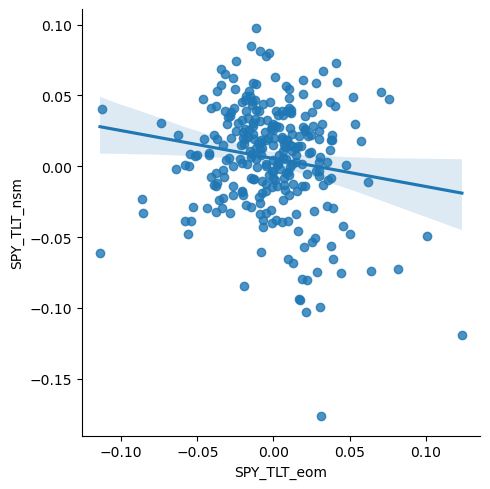

In [123]:
# plot using seaborn
sns.lmplot(x='SPY_TLT_eom', y='SPY_TLT_nsm', data=return_data)
plt.show()

## Relationship between SOM and Next SOM

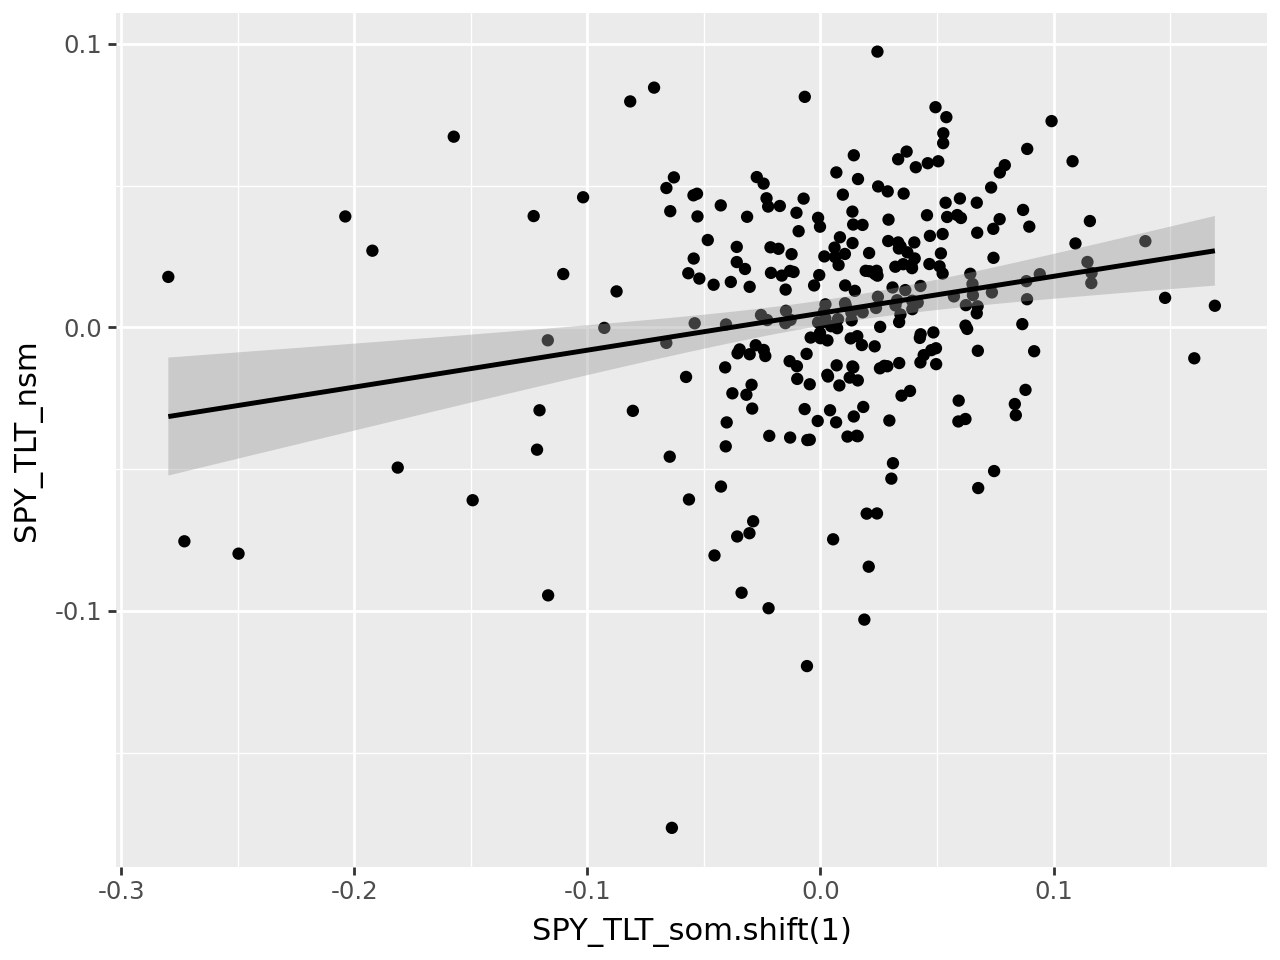

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_nsm   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     13.11
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           0.000349
Time:                        19:06:45   Log-Likelihood:                 521.02
No. Observations:                 279   AIC:                            -1038.
Df Residuals:                     277   BIC:                            -1031.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0050 

In [124]:
# plot using plotnine
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_som.shift(1)', y='SPY_TLT_nsm')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()

mod = smf.ols('SPY_TLT_nsm ~ SPY_TLT_som.shift(1)', return_data)
res = mod.fit()
print(res.summary())

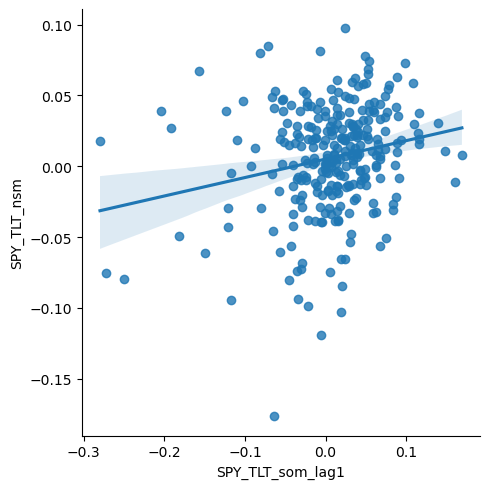

In [125]:
# Create shifted column, then plot using seaborn
return_data_shifted = return_data.assign(SPY_TLT_som_lag1=lambda x: x['SPY_TLT_som'].shift(1))

sns.lmplot(x='SPY_TLT_som_lag1', y='SPY_TLT_nsm', data=return_data_shifted)
plt.show()

## Backtesting

In [126]:
return_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm
ym,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048050
2002-09-30,-0.104852,-0.120565,-0.026590,-0.020469
2002-10-31,0.082284,0.169239,-0.043636,-0.029224
2002-11-30,0.061680,0.062209,0.003899,0.007640
2002-12-31,-0.056570,-0.062908,-0.037998,-0.032310


In [127]:
# Generate the trading flag
# If SPY_TLT_som < 0 → flag = +1 (LONG TLT / SHORT SPY)
# Else → flag = -1 (LONG SPY / SHORT TLT)
pl_data = return_data.copy()
pl_data['flag'] = np.where(pl_data['SPY_TLT_som'] < 0, 1, -1)

pl_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag
ym,,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048050,-1
2002-09-30,-0.104852,-0.120565,-0.026590,-0.020469,1
2002-10-31,0.082284,0.169239,-0.043636,-0.029224,-1
2002-11-30,0.061680,0.062209,0.003899,0.007640,-1
2002-12-31,-0.056570,-0.062908,-0.037998,-0.032310,1


In [128]:
# Compute P/L for the end-of-month (EOM) window
# Multiply the flag by SPY_TLT_eom (the relative performance)
pl_data['SPY_TLT_eom_pl'] = pl_data['flag'] * pl_data['SPY_TLT_eom']

pl_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl
ym,,,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048050,-1,0.056100
2002-09-30,-0.104852,-0.120565,-0.026590,-0.020469,1,-0.026590
2002-10-31,0.082284,0.169239,-0.043636,-0.029224,-1,0.043636
2002-11-30,0.061680,0.062209,0.003899,0.007640,-1,-0.003899
2002-12-31,-0.056570,-0.062908,-0.037998,-0.032310,1,-0.037998


In [129]:
# Compute P/L for the next-start-of-month (NSM) window
# Use the opposite position of the previous month (shifted flag)
# Fill the first NaN value with 0.0 since no previous signal exists
pl_data['flag_shifted'] = pl_data['flag'].shift(1)
pl_data['SPY_TLT_nsm_pl'] = (-pl_data['flag_shifted'] * pl_data['SPY_TLT_nsm']).fillna(0.0)

pl_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl
ym,,,,,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048050,-1,0.056100,NaN,0.000000
2002-09-30,-0.104852,-0.120565,-0.026590,-0.020469,1,-0.026590,-1.0,-0.020469
2002-10-31,0.082284,0.169239,-0.043636,-0.029224,-1,0.043636,1.0,0.029224
2002-11-30,0.061680,0.062209,0.003899,0.007640,-1,-0.003899,-1.0,0.007640
2002-12-31,-0.056570,-0.062908,-0.037998,-0.032310,1,-0.037998,-1.0,-0.032310


In [130]:
# Compute total monthly P/L
# Combine the EOM and NSM profits/losses
pl_data['pl'] = pl_data['SPY_TLT_eom_pl'] + pl_data['SPY_TLT_nsm_pl']

pl_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl,pl
ym,,,,,,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048050,-1,0.056100,NaN,0.000000,0.056100
2002-09-30,-0.104852,-0.120565,-0.026590,-0.020469,1,-0.026590,-1.0,-0.020469,-0.047060
2002-10-31,0.082284,0.169239,-0.043636,-0.029224,-1,0.043636,1.0,0.029224,0.072860
2002-11-30,0.061680,0.062209,0.003899,0.007640,-1,-0.003899,-1.0,0.007640,0.003741
2002-12-31,-0.056570,-0.062908,-0.037998,-0.032310,1,-0.037998,-1.0,-0.032310,-0.070308


In [131]:
"""
cpl_full, green, combined P&L from month end and next start of month
cpl_nsm, blue, combined P&L from next start of month only

""";

In [132]:
# Compute cumulative returns
# (1 + return).cumprod() gives the total compounded performance
pl_data['cpl_nsm'] = (1 + pl_data['SPY_TLT_nsm_pl']).cumprod()
pl_data['cpl_full'] = (1 + pl_data['pl']).cumprod()
pl_data['SPY'] = (1 + pl_data['SPY_ret']).cumprod()

pl_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl,pl,cpl_nsm,cpl_full,SPY
ym,,,,,,,,,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048050,-1,0.056100,NaN,0.000000,0.056100,1.000000,1.056100,1.006801
2002-09-30,-0.104852,-0.120565,-0.026590,-0.020469,1,-0.026590,-1.0,-0.020469,-0.047060,0.979531,1.006400,0.901236
2002-10-31,0.082284,0.169239,-0.043636,-0.029224,-1,0.043636,1.0,0.029224,0.072860,1.008157,1.079727,0.975393
2002-11-30,0.061680,0.062209,0.003899,0.007640,-1,-0.003899,-1.0,0.007640,0.003741,1.015859,1.083767,1.035556
2002-12-31,-0.056570,-0.062908,-0.037998,-0.032310,1,-0.037998,-1.0,-0.032310,-0.070308,0.983036,1.007569,0.976975


In [133]:
# Reset index for visualization and final output
pl_data = pl_data.reset_index()

pl_data.tail()

,ym,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl,pl,cpl_nsm,cpl_full,SPY
275,2025-07-31,0.023032,0.033781,0.000007,0.025906,-1,-0.000007,-1.0,0.025906,0.025899,7.233542,32.415361,10.625807
276,2025-08-31,0.020520,0.006702,0.012749,-0.012571,-1,-0.012749,-1.0,-0.012571,-0.025320,7.142610,31.594611,10.843844
277,2025-09-30,0.035620,0.007519,-0.008637,-0.033473,-1,0.008637,-1.0,-0.033473,-0.024836,6.903527,30.809937,11.230106
278,2025-10-31,0.023837,-0.025525,0.035127,0.002909,1,0.035127,-1.0,0.002909,0.038036,6.923608,31.981818,11.497803
279,2025-11-30,0.001877,0.004378,0.000000,0.004378,-1,-0.000000,1.0,-0.004378,-0.004378,6.893298,31.841812,11.519381


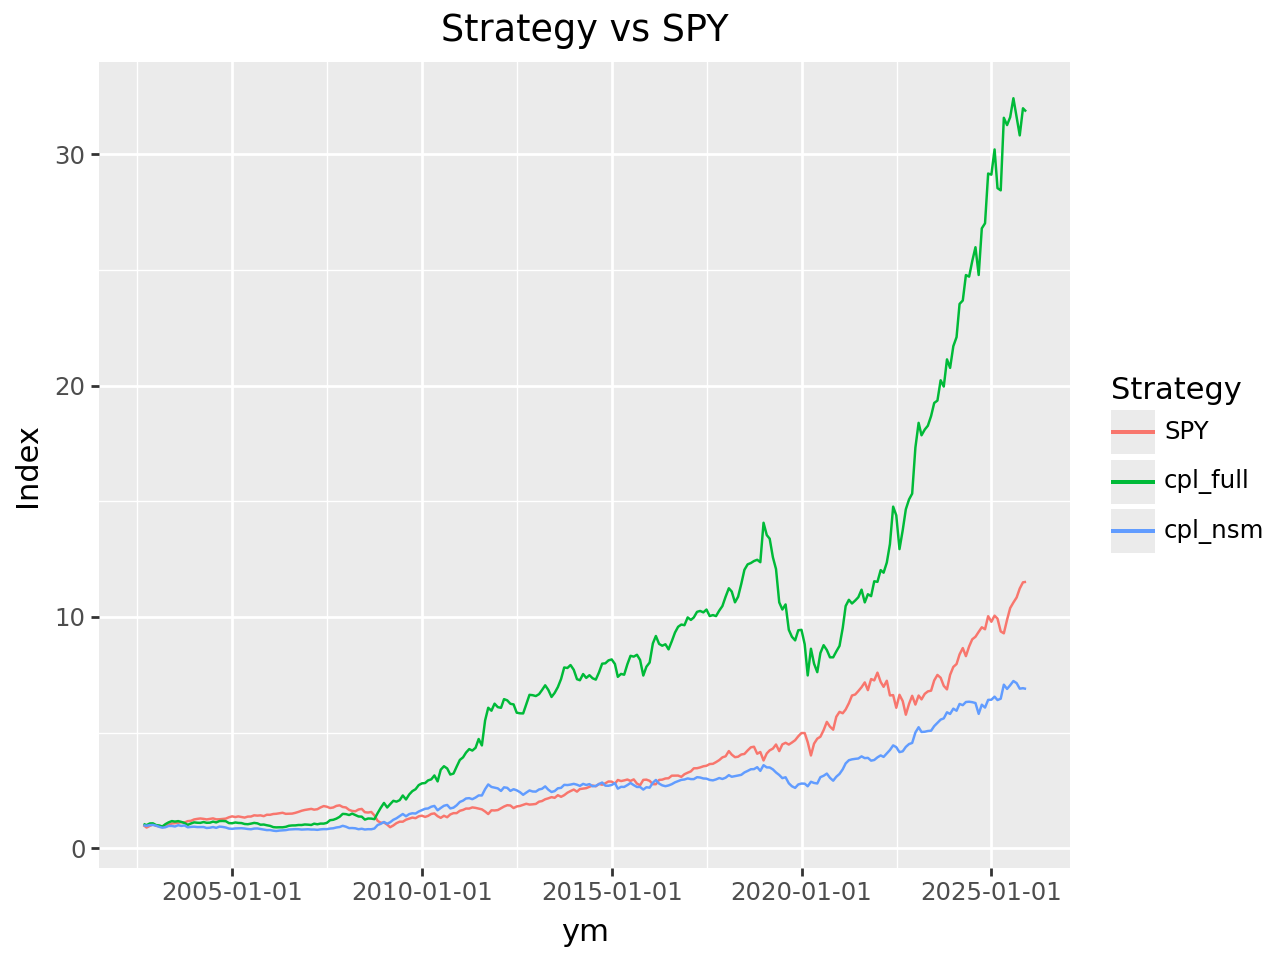

In [134]:
(
    pl_data
    [['ym', 'cpl_nsm', 'cpl_full', 'SPY']]
    .melt(id_vars='ym', var_name='Strategy', value_name='Index')
    .pipe(p9.ggplot)
    + p9.aes(x='ym', y='Index', color='Strategy')
    + p9.geom_line()
    + p9.ggtitle('Strategy vs SPY')
)

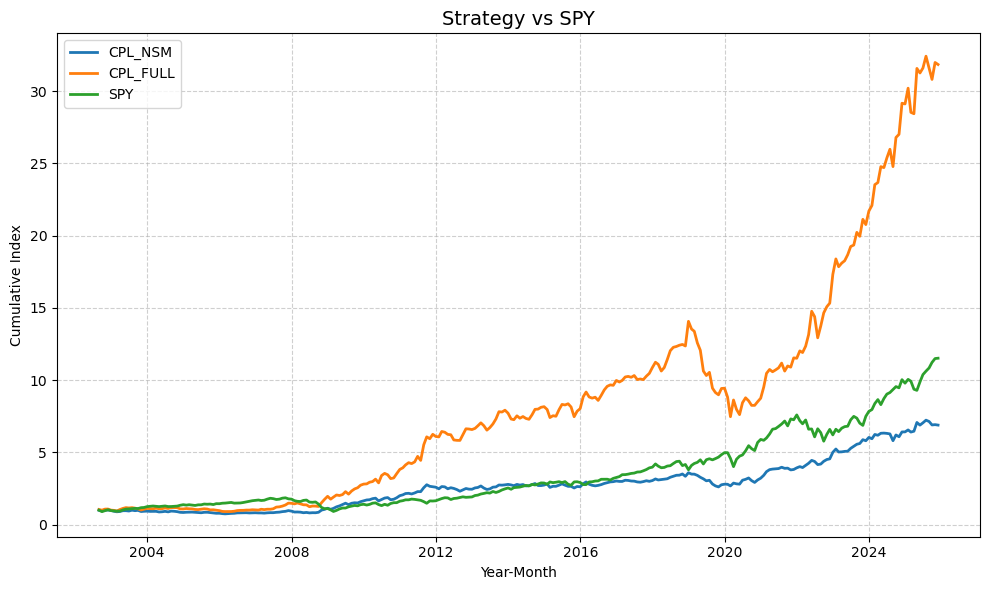

In [135]:
# Prepare data
df_plot = pl_data[['ym', 'cpl_nsm', 'cpl_full', 'SPY']].copy()

# Create the figure
plt.figure(figsize=(10, 6))

# Plot each line
plt.plot(df_plot['ym'], df_plot['cpl_nsm'], label='CPL_NSM', linewidth=2)
plt.plot(df_plot['ym'], df_plot['cpl_full'], label='CPL_FULL', linewidth=2)
plt.plot(df_plot['ym'], df_plot['SPY'], label='SPY', linewidth=2)

# Add title and labels
plt.title('Strategy vs SPY', fontsize=14)
plt.xlabel('Year-Month')
plt.ylabel('Cumulative Index')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

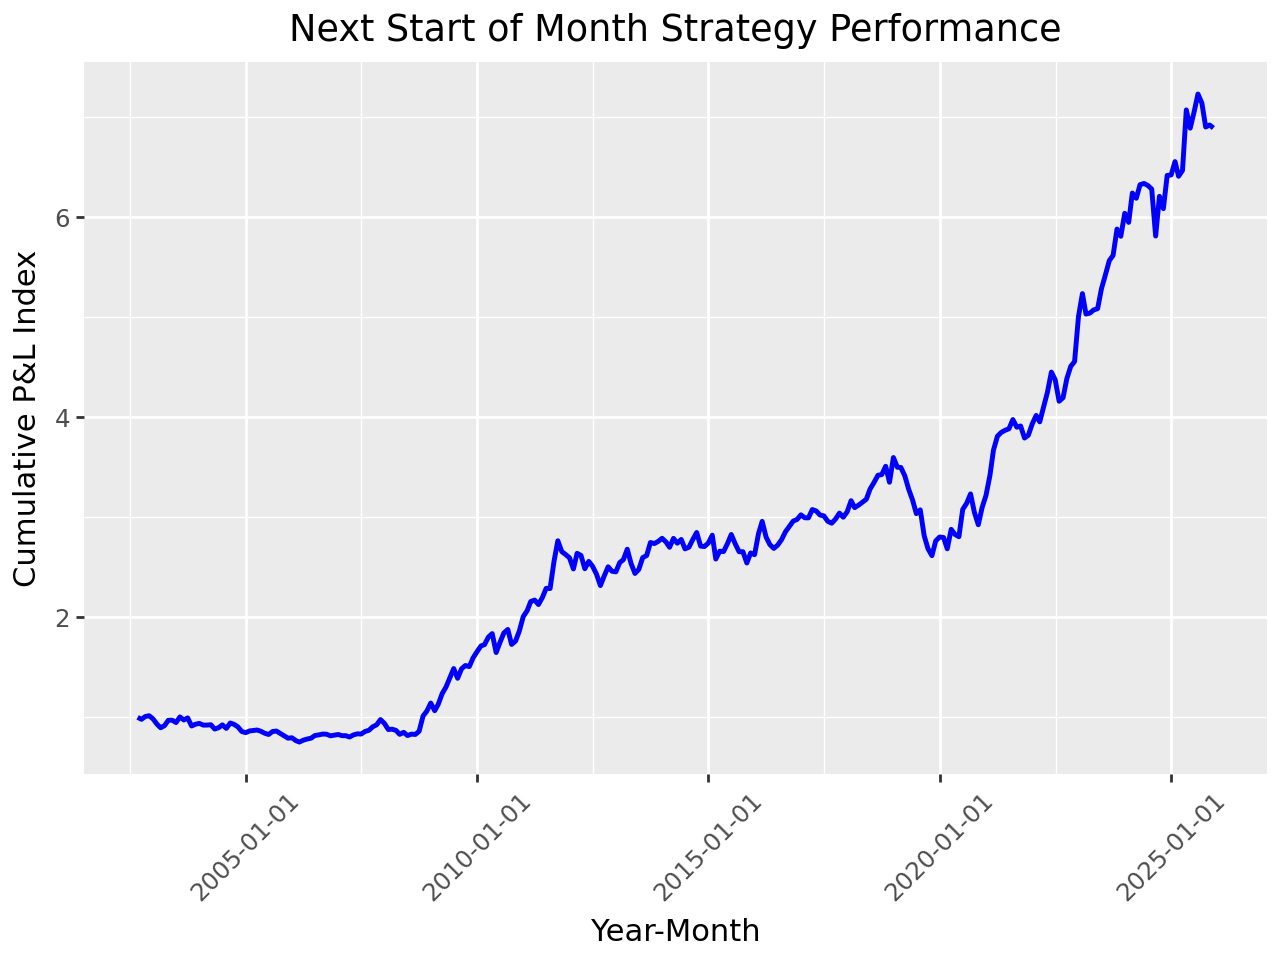

In [136]:
# Plot Next Start of Month Strategy only
(
    pl_data
    [['ym', 'cpl_nsm']]
    .pipe(p9.ggplot)
    + p9.aes(x='ym', y='cpl_nsm')
    + p9.geom_line(color='blue', size=1)
    + p9.ggtitle('Next Start of Month Strategy Performance')
    + p9.xlab('Year-Month')
    + p9.ylab('Cumulative P&L Index')
    + p9.theme(axis_text_x=p9.element_text(rotation=45))
)

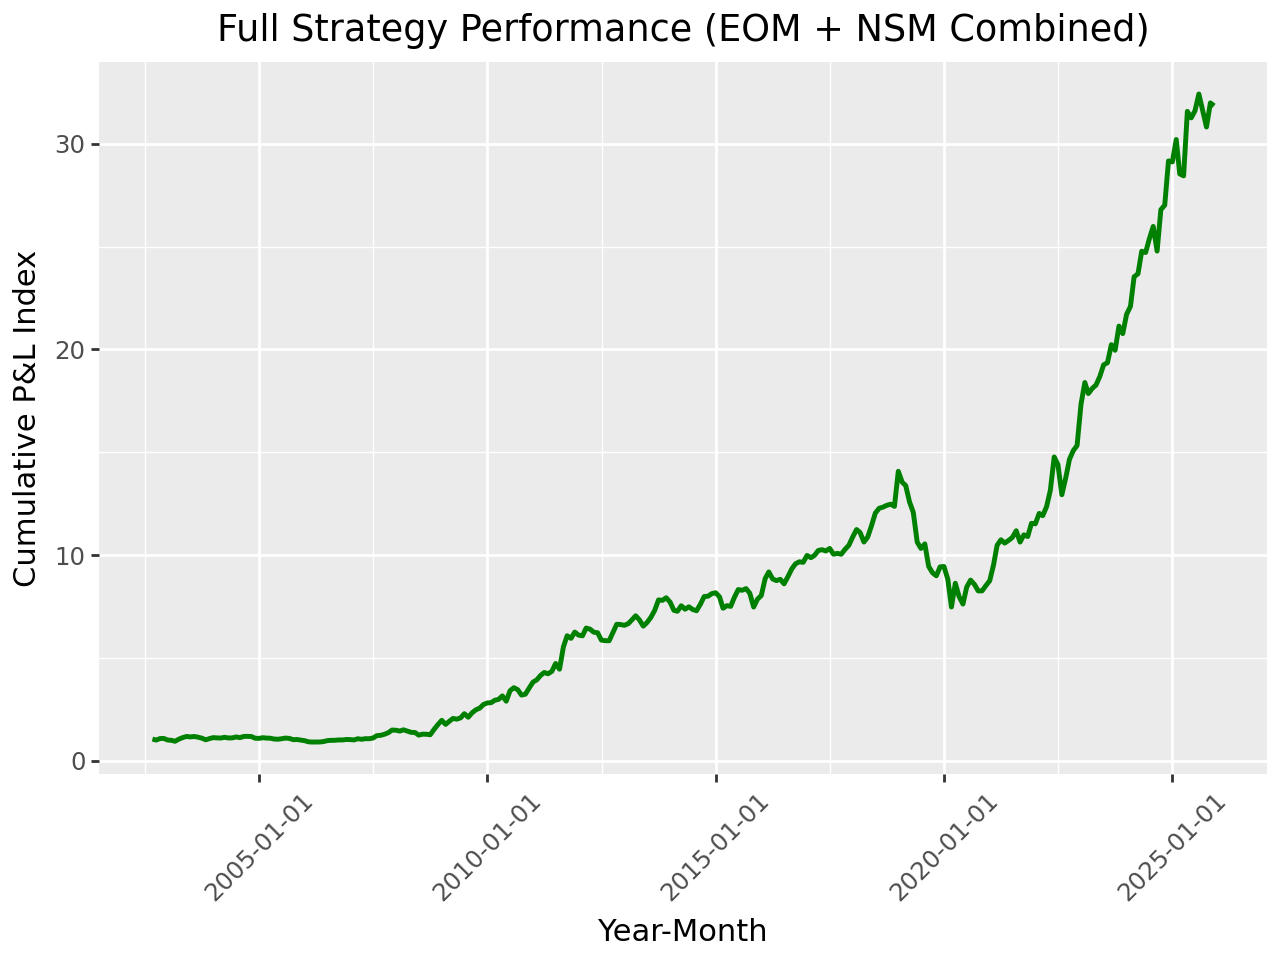

In [137]:
# Plot Full Strategy only
(
    pl_data
    [['ym', 'cpl_full']]
    .pipe(p9.ggplot)
    + p9.aes(x='ym', y='cpl_full')
    + p9.geom_line(color='green', size=1)
    + p9.ggtitle('Full Strategy Performance (EOM + NSM Combined)')
    + p9.xlab('Year-Month')
    + p9.ylab('Cumulative P&L Index')
    + p9.theme(axis_text_x=p9.element_text(rotation=45))
)

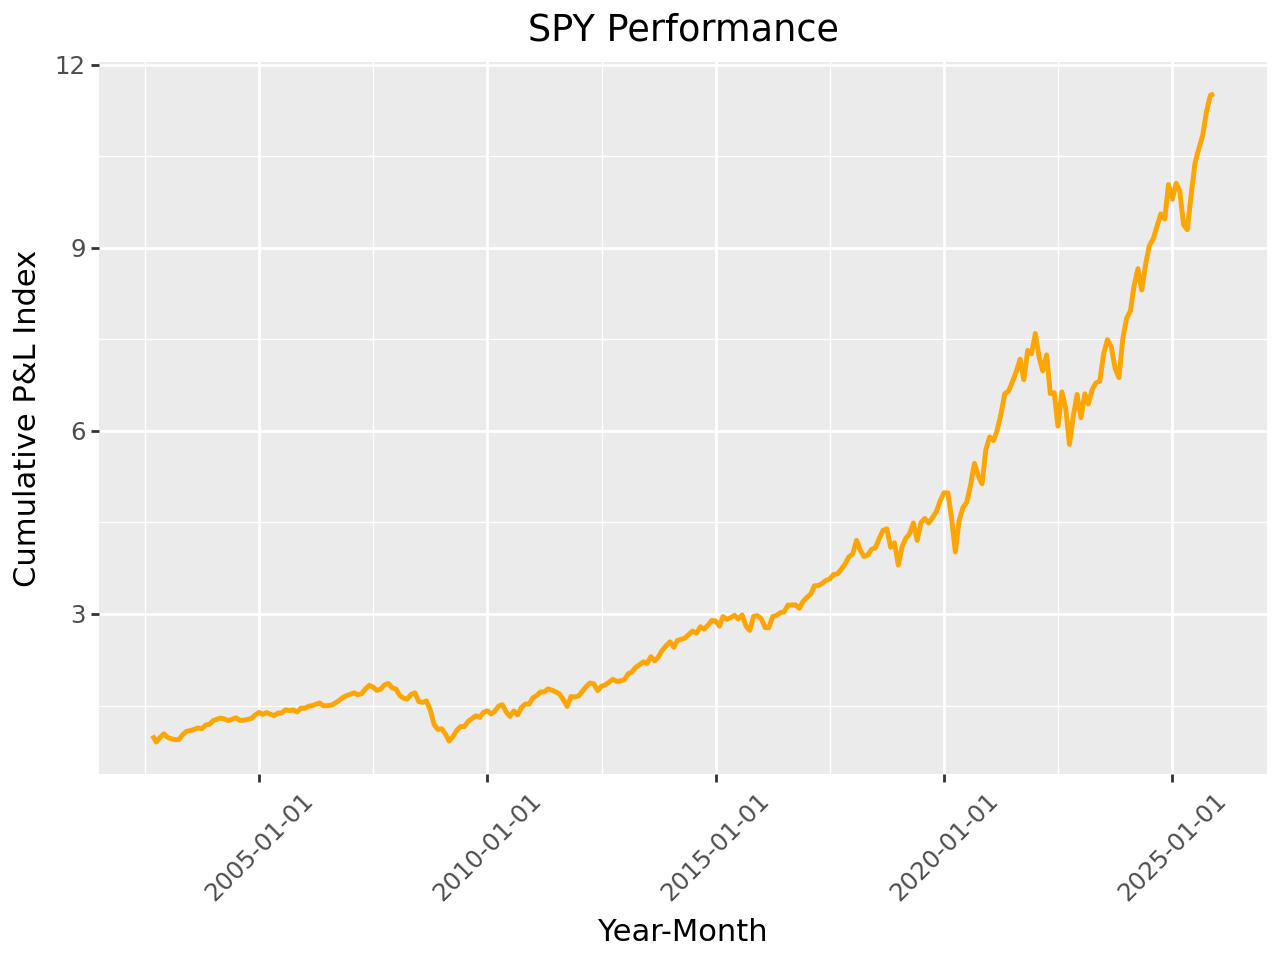

In [138]:
# Plot SPY only
(
    pl_data
    [['ym', 'SPY']]
    .pipe(p9.ggplot)
    + p9.aes(x='ym', y='SPY')
    + p9.geom_line(color='orange', size=1)
    + p9.ggtitle('SPY Performance')
    + p9.xlab('Year-Month')
    + p9.ylab('Cumulative P&L Index')
    + p9.theme(axis_text_x=p9.element_text(rotation=45))
)

In [139]:
ret_strategy = pl_data['pl'].mean() * 12
vol_strategy = pl_data['pl'].std() * np.sqrt(12)
sr_strategy = ret_strategy / vol_strategy
mdd_strategy = (pl_data['cpl_full']/pl_data['cpl_full'].expanding().max() - 1.0).min()

ret_nsm = pl_data['SPY_TLT_nsm_pl'].mean() * 12
vol_nsm = pl_data['SPY_TLT_nsm_pl'].std() * np.sqrt(12)
sr_nsm = ret_strategy / vol_strategy
mdd_nsm = (pl_data['cpl_nsm']/pl_data['cpl_nsm'].expanding().max() - 1.0).min()

ret_spy = pl_data['SPY_ret'].mean() * 12
vol_spy = pl_data['SPY_ret'].std() * np.sqrt(12)
sr_spy = ret_spy / vol_spy
mdd_spy = (pl_data['SPY'] / pl_data['SPY'].expanding().max() - 1.0).min()

print(f'Next SOM Return = {ret_nsm:.2%}, Strategy Vol = {vol_nsm:.2%}, Strategy Sharpe = {sr_nsm:.2f}, Strategy Max DrawDown = {mdd_nsm:.2%}')
print(f'Strategy Return = {ret_strategy:.2%}, Strategy Vol = {vol_strategy:.2%}, Strategy Sharpe = {sr_strategy:.2f}, Strategy Max DrawDown = {mdd_strategy:.2%}')
print(f'SPY Return      = {ret_spy:.2%}, SPY Vol      = {vol_spy:.2%}, SPY Sharpe      = {sr_spy:.2f}, SPY Max DrawDown      = {mdd_spy:.2%}')

Next SOM Return = 9.15%, Strategy Vol = 13.15%, Strategy Sharpe = 0.92, Strategy Max DrawDown = -27.28%
Strategy Return = 16.47%, Strategy Vol = 17.89%, Strategy Sharpe = 0.92, Strategy Max DrawDown = -46.88%
SPY Return      = 11.61%, SPY Vol      = 14.71%, SPY Sharpe      = 0.79, SPY Max DrawDown      = -50.78%


In [140]:
"""
cpl_full, green, combined P&L from month end and next start of month
cpl_nsm, blue, combined P&L from next start of month only

""";

In [141]:
pl_data.head()

,ym,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl,pl,cpl_nsm,cpl_full,SPY
0,2002-08-31,0.006801,0.008097,-0.056100,-0.048050,-1,0.056100,NaN,0.000000,0.056100,1.000000,1.056100,1.006801
1,2002-09-30,-0.104852,-0.120565,-0.026590,-0.020469,1,-0.026590,-1.0,-0.020469,-0.047060,0.979531,1.006400,0.901236
2,2002-10-31,0.082284,0.169239,-0.043636,-0.029224,-1,0.043636,1.0,0.029224,0.072860,1.008157,1.079727,0.975393
3,2002-11-30,0.061680,0.062209,0.003899,0.007640,-1,-0.003899,-1.0,0.007640,0.003741,1.015859,1.083767,1.035556
4,2002-12-31,-0.056570,-0.062908,-0.037998,-0.032310,1,-0.037998,-1.0,-0.032310,-0.070308,0.983036,1.007569,0.976975


In [142]:
pl_data.tail()

,ym,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl,pl,cpl_nsm,cpl_full,SPY
275,2025-07-31,0.023032,0.033781,0.000007,0.025906,-1,-0.000007,-1.0,0.025906,0.025899,7.233542,32.415361,10.625807
276,2025-08-31,0.020520,0.006702,0.012749,-0.012571,-1,-0.012749,-1.0,-0.012571,-0.025320,7.142610,31.594611,10.843844
277,2025-09-30,0.035620,0.007519,-0.008637,-0.033473,-1,0.008637,-1.0,-0.033473,-0.024836,6.903527,30.809937,11.230106
278,2025-10-31,0.023837,-0.025525,0.035127,0.002909,1,0.035127,-1.0,0.002909,0.038036,6.923608,31.981818,11.497803
279,2025-11-30,0.001877,0.004378,0.000000,0.004378,-1,-0.000000,1.0,-0.004378,-0.004378,6.893298,31.841812,11.519381


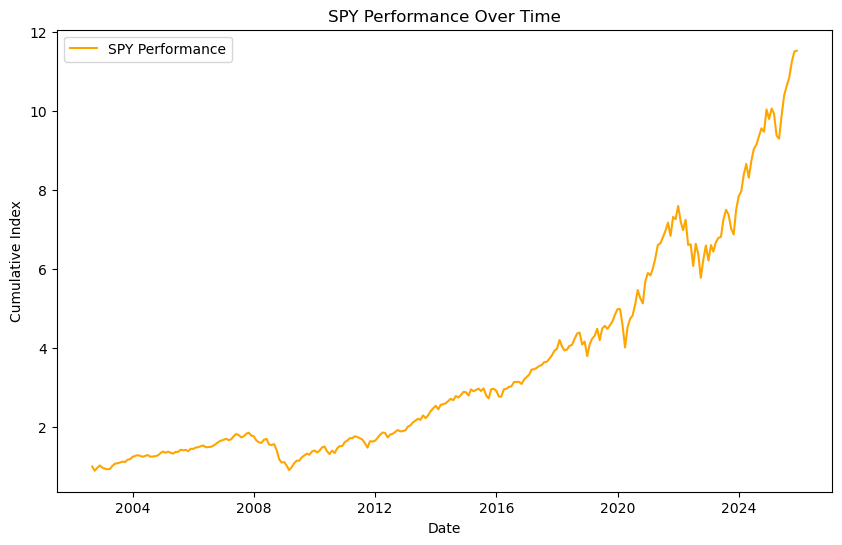

In [143]:
# simple plot pl_data.SPY and datetime to check data integrity
plt.figure(figsize=(10, 6))
plt.plot(pl_data['ym'], pl_data['SPY'], label='SPY Performance', color='orange')
plt.title('SPY Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Index')
plt.legend()
plt.show()

In [144]:
# # Calculate cumulative returns since inception
# print("=== CUMULATIVE RETURNS SINCE INCEPTION ===")
# print()

# # Get the final values (latest cumulative returns)
# final_cpl_full = pl_data['cpl_full'].iloc[-1]
# final_cpl_nsm = pl_data['cpl_nsm'].iloc[-1]
# final_spy = pl_data['SPY'].iloc[-1]

# # Convert to percentage returns since inception
# total_return_full_strategy = (final_cpl_full - 1) * 100
# total_return_nsm_strategy = (final_cpl_nsm - 1) * 100
# total_return_spy = (final_spy - 1) * 100

# # Calculate number of years for annualized calculation
# start_date = pl_data['ym'].iloc[0]
# end_date = pl_data['ym'].iloc[-1]
# years = (end_date - start_date).days / 365.25

# # Calculate annualized returns
# ann_return_full = ((final_cpl_full) ** (1/years) - 1) * 100
# ann_return_nsm = ((final_cpl_nsm) ** (1/years) - 1) * 100
# ann_return_spy_ann = ((final_spy) ** (1/years) - 1) * 100

# print(f"Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')} ({years:.1f} years)")
# print()

# print("TOTAL CUMULATIVE RETURNS:")
# print(f"Full Strategy (EOM + NSM):  {total_return_full_strategy:+.2f}%")
# print(f"NSM Strategy Only:          {total_return_nsm_strategy:+.2f}%")
# print(f"SPY Buy & Hold:             {total_return_spy:+.2f}%")
# print()

# print("ANNUALIZED RETURNS:")
# print(f"Full Strategy (EOM + NSM):  {ann_return_full:.2f}%")
# print(f"NSM Strategy Only:          {ann_return_nsm:.2f}%")
# print(f"SPY Buy & Hold:             {ann_return_spy_ann:.2f}%")
# print()

# print("OUTPERFORMANCE vs SPY:")
# print(f"Full Strategy vs SPY:       {total_return_full_strategy - total_return_spy:+.2f}% total")
# print(f"NSM Strategy vs SPY:        {total_return_nsm_strategy - total_return_spy:+.2f}% total")
# print(f"Full Strategy vs SPY (ann): {ann_return_full - ann_return_spy_ann:+.2f}% per year")
# print(f"NSM Strategy vs SPY (ann):  {ann_return_nsm - ann_return_spy_ann:+.2f}% per year")
# print()

# print("PERFORMANCE MULTIPLES:")
# print(f"$1 invested in Full Strategy would become: ${final_cpl_full:.2f}")
# print(f"$1 invested in NSM Strategy would become:  ${final_cpl_nsm:.2f}")
# print(f"$1 invested in SPY would become:           ${final_spy:.2f}")

In [145]:
# # Compute annualized return and volatility for the full strategy
# ret_strategy = pl_data['pl'].mean() * 12       # Annualized return
# vol_strategy = pl_data['pl'].std() * np.sqrt(12)  # Annualized volatility

# # Show values
# print("Annualized Return (Strategy):", round(ret_strategy * 100, 2), "%")
# print("Annualized Volatility (Strategy):", round(vol_strategy * 100, 2), "%")

In [146]:
# # Sharpe ratio
# sr_strategy = ret_strategy / vol_strategy

# # Max Drawdown (the lowest point compared to the previous peak)
# roll_max = pl_data['cpl_full'].expanding().max()
# drawdown = (pl_data['cpl_full'] / roll_max) - 1.0
# mdd_strategy = drawdown.min()

# # Show values
# print("Sharpe Ratio (Strategy):", round(sr_strategy, 2))
# print("Max Drawdown (Strategy):", round(mdd_strategy * 100, 2), "%")

In [147]:
# # Annualized return and volatility for Next SOM version
# ret_nsm = pl_data['SPY_TLT_nsm_pl'].mean() * 12
# vol_nsm = pl_data['SPY_TLT_nsm_pl'].std() * np.sqrt(12)

# # Sharpe ratio and Max Drawdown
# sr_nsm = ret_nsm / vol_nsm
# roll_max_nsm = pl_data['cpl_nsm'].expanding().max()
# drawdown_nsm = (pl_data['cpl_nsm'] / roll_max_nsm) - 1.0
# mdd_nsm = drawdown_nsm.min()

# # Show results
# print("Next SOM Return:", round(ret_nsm * 100, 2), "%")
# print("Next SOM Volatility:", round(vol_nsm * 100, 2), "%")
# print("Next SOM Sharpe:", round(sr_nsm, 2))
# print("Next SOM Max Drawdown:", round(mdd_nsm * 100, 2), "%")

In [148]:
# # Annualized return and volatility for SPY
# ret_spy = pl_data['SPY_ret'].mean() * 12
# vol_spy = pl_data['SPY_ret'].std() * np.sqrt(12)

# # Sharpe ratio and Max Drawdown
# sr_spy = ret_spy / vol_spy
# roll_max_spy = pl_data['SPY'].expanding().max()
# drawdown_spy = (pl_data['SPY'] / roll_max_spy) - 1.0
# mdd_spy = drawdown_spy.min()

# # Show results
# print("SPY Return:", round(ret_spy * 100, 2), "%")
# print("SPY Volatility:", round(vol_spy * 100, 2), "%")
# print("SPY Sharpe:", round(sr_spy, 2))
# print("SPY Max Drawdown:", round(mdd_spy * 100, 2), "%")

In [149]:
# # Create a summary table for easy comparison
# metrics = pd.DataFrame({
#     'Return [%]': [ret_strategy * 100, ret_nsm * 100, ret_spy * 100],
#     'Volatility [%]': [vol_strategy * 100, vol_nsm * 100, vol_spy * 100],
#     'Sharpe Ratio': [sr_strategy, sr_nsm, sr_spy],
#     'Max Drawdown [%]': [mdd_strategy * 100, mdd_nsm * 100, mdd_spy * 100]
# }, index=['Full Strategy', 'Next SOM', 'SPY'])

# # Add additional metrics (optional)
# metrics['Calmar Ratio'] = metrics['Return [%]'] / abs(metrics['Max Drawdown [%]'])
# metrics['Return/Volatility'] = metrics['Return [%]'] / metrics['Volatility [%]']

# # Display summary
# print("=== Backtest Performance Summary")
# metrics.round(2)

## Properties of SPY and TLT

### Metrics of SPY_TLT_som

In [150]:
# print pl_data info and shape
print(pl_data.info())
print(pl_data.shape)

# Display first few rows of pl_data
print('Dataset preview:')
pl_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ym              280 non-null    datetime64[ns]
 1   SPY_ret         280 non-null    float64       
 2   SPY_TLT_som     280 non-null    float64       
 3   SPY_TLT_eom     280 non-null    float64       
 4   SPY_TLT_nsm     280 non-null    float64       
 5   flag            280 non-null    int64         
 6   SPY_TLT_eom_pl  280 non-null    float64       
 7   flag_shifted    279 non-null    float64       
 8   SPY_TLT_nsm_pl  280 non-null    float64       
 9   pl              280 non-null    float64       
 10  cpl_nsm         280 non-null    float64       
 11  cpl_full        280 non-null    float64       
 12  SPY             280 non-null    float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 28.6 KB
None
(280, 13)
Dataset preview:


,ym,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl,pl,cpl_nsm,cpl_full,SPY
0,2002-08-31,0.006801,0.008097,-0.056100,-0.048050,-1,0.056100,NaN,0.000000,0.056100,1.000000,1.056100,1.006801
1,2002-09-30,-0.104852,-0.120565,-0.026590,-0.020469,1,-0.026590,-1.0,-0.020469,-0.047060,0.979531,1.006400,0.901236
2,2002-10-31,0.082284,0.169239,-0.043636,-0.029224,-1,0.043636,1.0,0.029224,0.072860,1.008157,1.079727,0.975393
3,2002-11-30,0.061680,0.062209,0.003899,0.007640,-1,-0.003899,-1.0,0.007640,0.003741,1.015859,1.083767,1.035556
4,2002-12-31,-0.056570,-0.062908,-0.037998,-0.032310,1,-0.037998,-1.0,-0.032310,-0.070308,0.983036,1.007569,0.976975


In [151]:
# length of SPY_TLT_som
print(f'Length of SPY_TLT_som: {len(pl_data["SPY_TLT_som"])}')

# count SPY_TLT_som > 0
count_positive = (pl_data['SPY_TLT_som'] > 0).sum()
print(f'Number of months with SPY_TLT_som > 0: {count_positive}')

# calculate percentage of months with SPY_TLT_som > 0
percentage_positive = (count_positive / len(pl_data)) * 100
print(f'Percentage of months with SPY_TLT_som > 0: {percentage_positive:.2f}%')

Length of SPY_TLT_som: 280
Number of months with SPY_TLT_som > 0: 173
Percentage of months with SPY_TLT_som > 0: 61.79%


### Average daily returns of TLT and SPY

In [152]:
# Keep only rows where the ticker is 'TLT' 
tlt = data[data['Ticker'] == 'TLT'].copy()

# Show first rows to check the result 
tlt.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
5,2002-08-01,2002-08-31,TLT,37.592636,0.005696,1,1,0,1,0.005696,0.0,0.005696
7,2002-08-02,2002-08-31,TLT,37.977619,0.010241,2,1,0,1,0.010241,0.0,0.010241
9,2002-08-05,2002-08-31,TLT,38.145203,0.004413,3,1,0,1,0.004413,0.0,0.004413
11,2002-08-06,2002-08-31,TLT,37.819099,-0.008549,4,1,0,1,-0.008549,-0.0,-0.008549
13,2002-08-07,2002-08-31,TLT,37.909664,0.002395,5,1,0,1,0.002395,0.0,0.002395


In [153]:
# Add 'ym' column as the end of the month for each date 
tlt['ym'] = tlt['Date'] + pd.offsets.MonthEnd(0)

# Calculate daily return based on the Close price 
tlt['ret'] = tlt['Close'].pct_change()

# Show the first few rows with new columns 
tlt.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
5,2002-08-01,2002-08-31,TLT,37.592636,NaN,1,1,0,1,0.005696,0.0,0.005696
7,2002-08-02,2002-08-31,TLT,37.977619,0.010241,2,1,0,1,0.010241,0.0,0.010241
9,2002-08-05,2002-08-31,TLT,38.145203,0.004413,3,1,0,1,0.004413,0.0,0.004413
11,2002-08-06,2002-08-31,TLT,37.819099,-0.008549,4,1,0,1,-0.008549,-0.0,-0.008549
13,2002-08-07,2002-08-31,TLT,37.909664,0.002395,5,1,0,1,0.002395,0.0,0.002395


In [154]:
# Keep only data after 1st August 2002 
tlt_filtered = tlt[tlt['Date'] >= dt.datetime(2002, 8, 1)].copy()

# Display a few rows to check 
tlt_filtered.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
5,2002-08-01,2002-08-31,TLT,37.592636,NaN,1,1,0,1,0.005696,0.0,0.005696
7,2002-08-02,2002-08-31,TLT,37.977619,0.010241,2,1,0,1,0.010241,0.0,0.010241
9,2002-08-05,2002-08-31,TLT,38.145203,0.004413,3,1,0,1,0.004413,0.0,0.004413
11,2002-08-06,2002-08-31,TLT,37.819099,-0.008549,4,1,0,1,-0.008549,-0.0,-0.008549
13,2002-08-07,2002-08-31,TLT,37.909664,0.002395,5,1,0,1,0.002395,0.0,0.002395


In [155]:
# Keep only data after 1st August 2002 
tlt_filtered = tlt[tlt['Date'] >= dt.datetime(2002, 8, 1)].copy()

# Display a few rows to check 
tlt_filtered.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
5,2002-08-01,2002-08-31,TLT,37.592636,NaN,1,1,0,1,0.005696,0.0,0.005696
7,2002-08-02,2002-08-31,TLT,37.977619,0.010241,2,1,0,1,0.010241,0.0,0.010241
9,2002-08-05,2002-08-31,TLT,38.145203,0.004413,3,1,0,1,0.004413,0.0,0.004413
11,2002-08-06,2002-08-31,TLT,37.819099,-0.008549,4,1,0,1,-0.008549,-0.0,-0.008549
13,2002-08-07,2002-08-31,TLT,37.909664,0.002395,5,1,0,1,0.002395,0.0,0.002395


In [156]:
# For each month, number the days starting from 1 
tlt_filtered['td'] = tlt_filtered.groupby('ym').cumcount() + 1

# Show some rows to verify 
tlt_filtered.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
5,2002-08-01,2002-08-31,TLT,37.592636,NaN,1,1,0,1,0.005696,0.0,0.005696
7,2002-08-02,2002-08-31,TLT,37.977619,0.010241,2,1,0,1,0.010241,0.0,0.010241
9,2002-08-05,2002-08-31,TLT,38.145203,0.004413,3,1,0,1,0.004413,0.0,0.004413
11,2002-08-06,2002-08-31,TLT,37.819099,-0.008549,4,1,0,1,-0.008549,-0.0,-0.008549
13,2002-08-07,2002-08-31,TLT,37.909664,0.002395,5,1,0,1,0.002395,0.0,0.002395


In [157]:
# Group by the trading day number and take the mean of returns 
avg_daily_returns = tlt_filtered.groupby('td')['ret'].mean().reset_index()

#  Display the last few rows to see results 
avg_daily_returns.tail()

,td,ret
18,19,0.001292
19,20,0.001198
20,21,0.001317
21,22,0.001578
22,23,0.001063


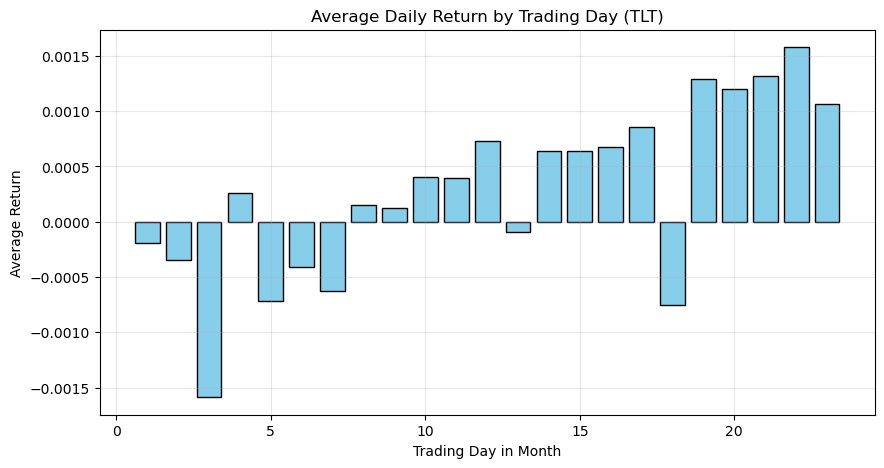

,td,ret
18,19,0.001292
19,20,0.001198
20,21,0.001317
21,22,0.001578
22,23,0.001063


In [158]:
# Plot average daily returns using matplotlib 
plt.figure(figsize=(10, 5))
plt.bar(avg_daily_returns['td'], avg_daily_returns['ret'], color='skyblue', edgecolor='black')

# Add labels and title 
plt.title("Average Daily Return by Trading Day (TLT)")
plt.xlabel("Trading Day in Month")
plt.ylabel("Average Return")
plt.grid(alpha=0.3)

plt.show()

# Show the last few rows of the data for reference 
avg_daily_returns.tail()

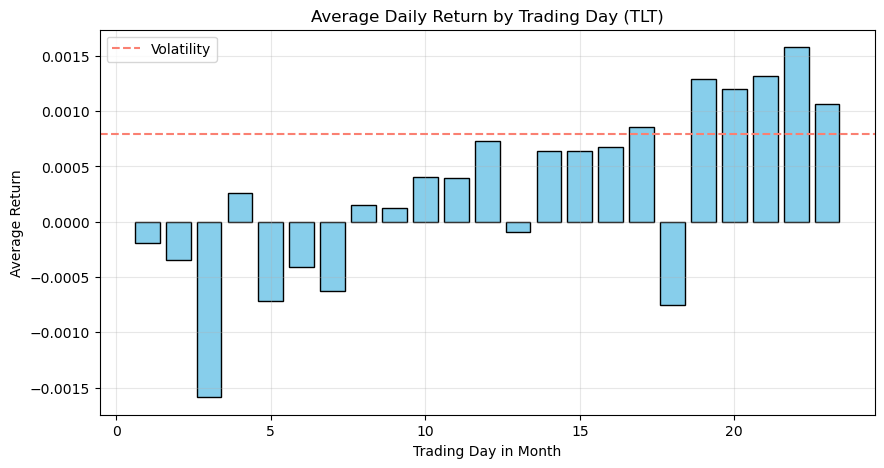

In [159]:
# calculate volatility of average daily returns
volatility = avg_daily_returns['ret'].std()

# plot volatility with ax line and avg_daily_returns with matplotlib
plt.figure(figsize=(10, 5))
plt.bar(avg_daily_returns['td'], avg_daily_returns['ret'], color='skyblue', edgecolor='black')
plt.axhline(y=volatility, color='salmon', linestyle='--', label='Volatility')
# Add labels and title 
plt.title("Average Daily Return by Trading Day (TLT)")
plt.xlabel("Trading Day in Month")
plt.ylabel("Average Return")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

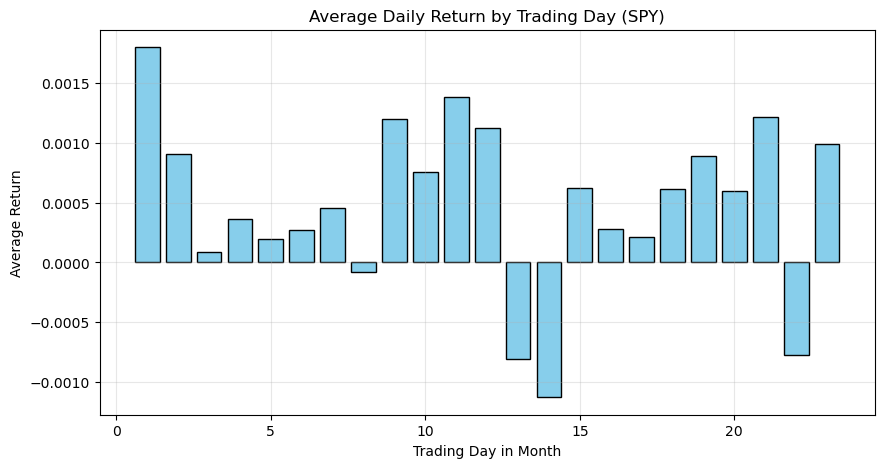

,td,ret
18,19,0.000888
19,20,0.000602
20,21,0.001214
21,22,-0.000770
22,23,0.000992


In [160]:
# Keep only rows where the ticker is 'SPY'
spy = data[data['Ticker'] == 'SPY'].copy()

# Add 'ym' column as the end of the month for each date
spy['ym'] = spy['Date'] + pd.offsets.MonthEnd(0)

# Calculate daily return based on the Close price
spy['ret'] = spy['Close'].pct_change()

# Keep only data after 1st August 2002
spy_filtered = spy[spy['Date'] >= dt.datetime(2002, 8, 1)].copy()

# For each month, number the days starting from 1
spy_filtered['td'] = spy_filtered.groupby('ym').cumcount() + 1

# Group by the trading day number and take the mean of returns
avg_daily_returns_spy = spy_filtered.groupby('td')['ret'].mean().reset_index()

# Plot average daily returns using matplotlib
plt.figure(figsize=(10, 5))
plt.bar(avg_daily_returns_spy['td'], avg_daily_returns_spy['ret'], color='skyblue', edgecolor='black')

# Add labels and title
plt.title("Average Daily Return by Trading Day (SPY)")
plt.xlabel("Trading Day in Month")
plt.ylabel("Average Return")
plt.grid(alpha=0.3)

plt.show()

# Show the last few rows of the data for reference
avg_daily_returns_spy.tail()

## Equity Risk Premium

In [161]:
# spy_ret = (
#     data
#     .query('Ticker == "SPY"')
#     .assign(
#         ret=lambda x: x['Close'].pct_change(),
#         retp=lambda x: np.select([x['ret'] > 0], [x['ret']], [np.nan]),
#         retn=lambda x: np.select([x['ret'] < 0], [x['ret']], [np.nan]),
#     )
#     [['Date', 'ret', 'retp', 'retn']]
#     .melt(id_vars='Date', value_name='retrn', var_name='type')  # cannot use return, since it is a reserved keyword in Python and screws up syntax below
# )

# print(f'mean of returns is = {spy_ret.query("type==`ret`").retrn.mean():.4%}')
# print(f'mean of positive returns = {spy_ret.query("(type==`retp`) & (~retrn.isna())").retrn.mean():.4%}')
# print(f'mean of negative returns = {spy_ret.query("(type==`retn`) & (~retrn.isna())").retrn.mean():.4%}')

# (
#     spy_ret
#     .pipe(p9.ggplot)
#     + p9.aes(x='factor(type)', y='retrn')
#     + p9.geom_boxplot()
# ).show()

mean of returns is = 0.0494%
mean of positive returns = 0.7465%
mean of negative returns = -0.8154%


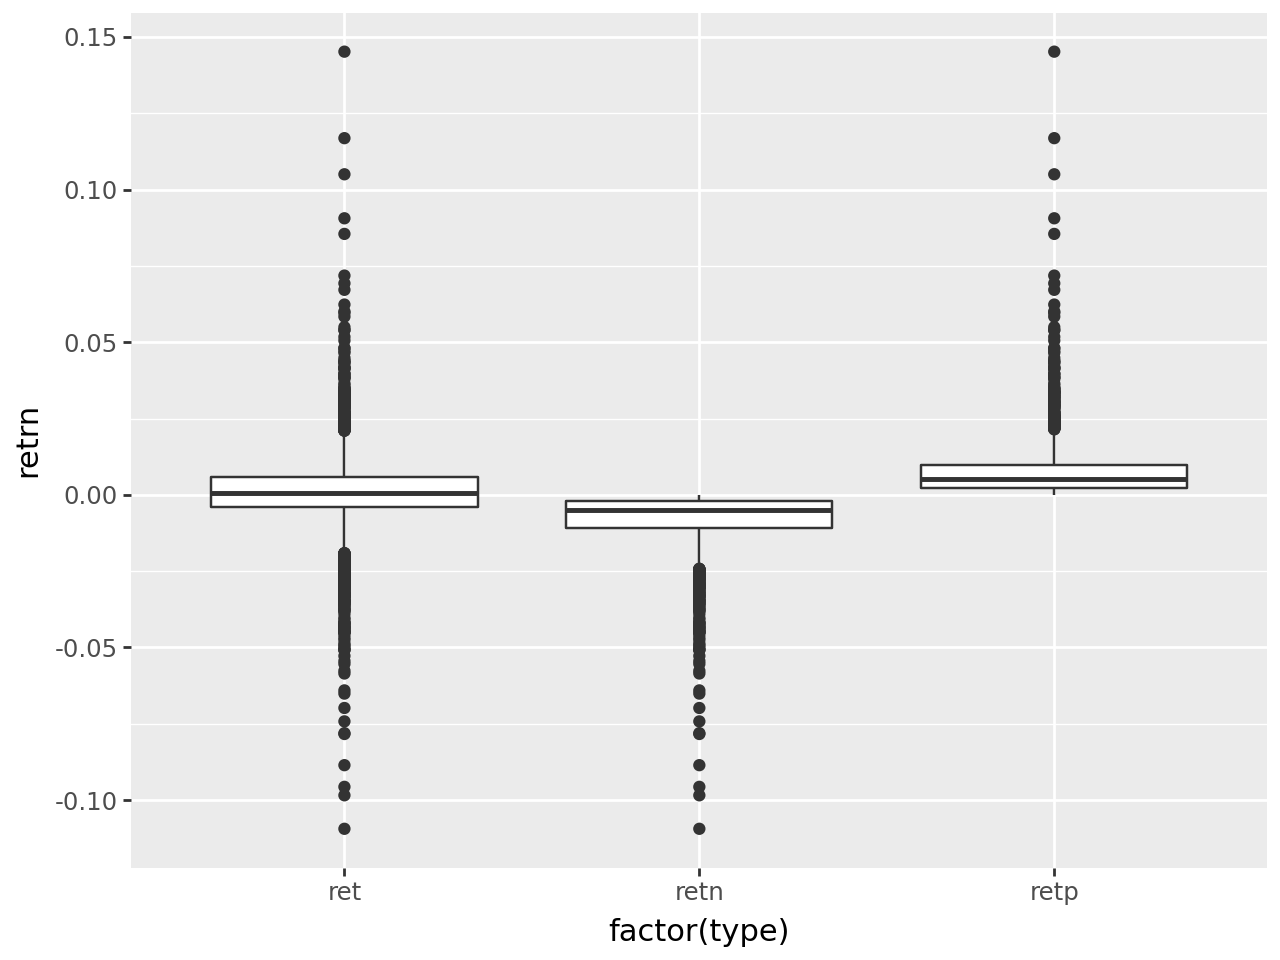

In [162]:
spy_ret = (
    data
    .query('Ticker == "SPY"')
    .assign(
        ret=lambda x: x['Close'].pct_change(),
        retp=lambda x: np.select([x['ret'] > 0], [x['ret']], [np.nan]),
        retn=lambda x: np.select([x['ret'] < 0], [x['ret']], [np.nan]),
    )
    [['Date', 'ret', 'retp', 'retn']]
    .melt(id_vars='Date', value_name='retrn', var_name='type')
)

# print(f'mean of returns is = {spy_ret[spy_ret["type"] == "ret"]["retrn"].mean():.4%}')
# print(f'mean of positive returns = {spy_ret[(spy_ret["type"] == "retp") & (~spy_ret["retrn"].isna())]["retrn"].mean():.4%}')
# print(f'mean of negative returns = {spy_ret[(spy_ret["type"] == "retn") & (~spy_ret["retrn"].isna())]["retrn"].mean():.4%}')

print(f'mean of returns is = {spy_ret.loc[spy_ret["type"] == "ret", "retrn"].mean():.4%}')
print(f'mean of positive returns = {spy_ret.loc[(spy_ret["type"] == "retp") & (~spy_ret["retrn"].isna()), "retrn"].mean():.4%}')
print(f'mean of negative returns = {spy_ret.loc[(spy_ret["type"] == "retn") & (~spy_ret["retrn"].isna()), "retrn"].mean():.4%}')

(
    spy_ret
    .pipe(p9.ggplot)
    + p9.aes(x='factor(type)', y='retrn')
    + p9.geom_boxplot()
).show()

## Backtesting (8 PL streams in the backtesting)

In [163]:
# display first few rows of the backtest df
print('Backtest data preview:')
backtest_data.head(35)

Backtest data preview:


,Date,ym,SPY_ret_som,TLT_ret_som,SPY_ret_eom,TLT_ret_eom,SPY_ret_nsm,TLT_ret_nsm
0,2002-08-01,2002-08-31,-0.026108,0.005696,-0.000000,0.000000,-0.026108,0.005696
1,2002-08-02,2002-08-31,-0.022415,0.010241,-0.000000,0.000000,-0.022415,0.010241
2,2002-08-05,2002-08-31,-0.034797,0.004413,-0.000000,0.000000,-0.034797,0.004413
3,2002-08-06,2002-08-31,0.033664,-0.008549,0.000000,-0.000000,0.033664,-0.008549
4,2002-08-07,2002-08-31,0.017438,0.002395,0.000000,0.000000,0.017438,0.002395
5,2002-08-08,2002-08-31,0.032350,0.000000,0.000000,0.000000,0.000000,0.000000
6,2002-08-09,2002-08-31,0.003738,0.014098,0.000000,0.000000,0.000000,0.000000
7,2002-08-12,2002-08-31,-0.007340,0.006127,-0.000000,0.000000,-0.000000,0.000000
8,2002-08-13,2002-08-31,-0.018208,0.012295,-0.000000,0.000000,-0.000000,0.000000
9,2002-08-14,2002-08-31,0.036529,0.003817,0.000000,0.000000,0.000000,0.000000


In [164]:
"""
ret column is the pct change of Close price for each ticker, for each day
ret_som is the return for the start of month window (first N trading days) for each ticker
ret_eom is the return for the end of month window (after first N trading days) for each ticker
ret_nsm is the return for the next start of month window (first M trading days) for each ticker
"""

'\nret column is the pct change of Close price for each ticker, for each day\nret_som is the return for the start of month window (first N trading days) for each ticker\nret_eom is the return for the end of month window (after first N trading days) for each ticker\nret_nsm is the return for the next start of month window (first M trading days) for each ticker\n'

In [165]:
# add column SPY_ret (calculated from daily returns)
backtest_data['SPY_ret'] = backtest_data['SPY_ret_som'] + backtest_data['SPY_ret_eom']

# display first few rows of the backtest df with new column
print('Backtest data with SPY_ret preview:')
print(backtest_data[['SPY_ret']].head())

# display full dataset
print('Full Backtest data:')
print(backtest_data.head())

Backtest data with SPY_ret preview:
    SPY_ret
0 -0.026108
1 -0.022415
2 -0.034797
3  0.033664
4  0.017438
Full Backtest data:
        Date         ym  SPY_ret_som  TLT_ret_som  SPY_ret_eom  TLT_ret_eom  \
0 2002-08-01 2002-08-31    -0.026108     0.005696         -0.0          0.0   
1 2002-08-02 2002-08-31    -0.022415     0.010241         -0.0          0.0   
2 2002-08-05 2002-08-31    -0.034797     0.004413         -0.0          0.0   
3 2002-08-06 2002-08-31     0.033664    -0.008549          0.0         -0.0   
4 2002-08-07 2002-08-31     0.017438     0.002395          0.0          0.0   

   SPY_ret_nsm  TLT_ret_nsm   SPY_ret  
0    -0.026108     0.005696 -0.026108  
1    -0.022415     0.010241 -0.022415  
2    -0.034797     0.004413 -0.034797  
3     0.033664    -0.008549  0.033664  
4     0.017438     0.002395  0.017438  


In [166]:
# add column SPY_TLT_som (calculated from daily returns)
backtest_data['SPY_TLT_som'] = backtest_data['SPY_ret_som'] - backtest_data['TLT_ret_som']

# display first few rows of the backtest df with new column
print('Backtest data with SPY_TLT_som preview:')
print(backtest_data[['SPY_TLT_som']].head(10))

Backtest data with SPY_TLT_som preview:
   SPY_TLT_som
0    -0.031804
1    -0.032656
2    -0.039209
3     0.042213
4     0.015043
5     0.032350
6    -0.010360
7    -0.013466
8    -0.030503
9     0.032712


In [167]:
backtest_data.head()

,Date,ym,SPY_ret_som,TLT_ret_som,SPY_ret_eom,TLT_ret_eom,SPY_ret_nsm,TLT_ret_nsm,SPY_ret,SPY_TLT_som
0,2002-08-01,2002-08-31,-0.026108,0.005696,-0.0,0.0,-0.026108,0.005696,-0.026108,-0.031804
1,2002-08-02,2002-08-31,-0.022415,0.010241,-0.0,0.0,-0.022415,0.010241,-0.022415,-0.032656
2,2002-08-05,2002-08-31,-0.034797,0.004413,-0.0,0.0,-0.034797,0.004413,-0.034797,-0.039209
3,2002-08-06,2002-08-31,0.033664,-0.008549,0.0,-0.0,0.033664,-0.008549,0.033664,0.042213
4,2002-08-07,2002-08-31,0.017438,0.002395,0.0,0.0,0.017438,0.002395,0.017438,0.015043


In [168]:
# drop Date column
backtest_data = backtest_data.drop(columns=['Date'])

# group by ym and sum the returns
monthly_backtest_data = backtest_data.groupby('ym').sum().reset_index()

# columns order SPY_ret	SPY_TLT_som	SPY_ret_eom	TLT_ret_eom	SPY_ret_nsm	TLT_ret_nsm
monthly_backtest_data = monthly_backtest_data[['ym', 'SPY_ret', 'SPY_TLT_som', 'SPY_ret_eom', 'TLT_ret_eom', 'SPY_ret_nsm', 'TLT_ret_nsm']]

monthly_backtest_data.head(10)

,ym,SPY_ret,SPY_TLT_som,SPY_ret_eom,TLT_ret_eom,SPY_ret_nsm,TLT_ret_nsm
0,2002-08-31,0.011222,0.013472,-0.041723,0.014861,-0.032218,0.014195
1,2002-09-30,-0.107556,-0.124964,-0.021354,0.003458,-0.011274,0.007362
2,2002-10-31,0.085516,0.165904,-0.017801,0.025720,-0.031047,-0.004315
3,2002-11-30,0.062012,0.064403,-0.000568,-0.006281,0.025647,0.016294
4,2002-12-31,-0.056567,-0.063066,-0.019432,0.018620,-0.020782,0.011799
5,2003-01-31,-0.022646,0.018810,-0.029358,0.007022,0.035964,-0.017635
6,2003-02-28,-0.012349,-0.036832,0.013288,0.019589,-0.031000,0.007667
7,2003-03-31,0.005016,0.106524,-0.055651,0.032798,-0.018517,0.004779
8,2003-04-30,0.082770,0.084848,0.006536,0.019279,0.038752,-0.019003
9,2003-05-31,0.054414,-0.054775,0.045703,-0.001547,0.016136,0.014552


In [169]:
# add column signal_eom when SPY_TLT_som > 0, -1, else +1
monthly_backtest_data['signal_eom'] = np.where(monthly_backtest_data['SPY_TLT_som'] > 0, -1, 1)

In [170]:
# add column signal_som when SPY_TLT_som > 0, +1, else -1
monthly_backtest_data['signal_som'] = np.where(monthly_backtest_data['SPY_TLT_som'] > 0, 1, -1)

# display first few rows of the backtest df with new columns
print('Backtest data with signals preview:')
print(monthly_backtest_data[['ym', 'signal_eom', 'signal_som']].head(10))

Backtest data with signals preview:
          ym  signal_eom  signal_som
0 2002-08-31          -1           1
1 2002-09-30           1          -1
2 2002-10-31          -1           1
3 2002-11-30          -1           1
4 2002-12-31           1          -1
5 2003-01-31          -1           1
6 2003-02-28           1          -1
7 2003-03-31          -1           1
8 2003-04-30          -1           1
9 2003-05-31           1          -1


In [171]:
# # 2nd version of signal_som using shift of signal_eom
# # For next start of month (using previous month's signal)
# monthly_backtest_data['signal_som'] = monthly_backtest_data['signal_eom'].shift(1).fillna(0)

# # Apply to next start of month returns
# monthly_backtest_data['Start_of_Month_SPY_Long_SPY'] = np.where(
#     monthly_backtest_data['signal_som'] == 1,
#     monthly_backtest_data['SPY_ret_nsm'], 0
# )

In [172]:
# loc signal_som equal to 0 for first row, to match excel calculation
monthly_backtest_data.loc[0, 'signal_som'] = 0

In [173]:
monthly_backtest_data.head()

,ym,SPY_ret,SPY_TLT_som,SPY_ret_eom,TLT_ret_eom,SPY_ret_nsm,TLT_ret_nsm,signal_eom,signal_som
0,2002-08-31,0.011222,0.013472,-0.041723,0.014861,-0.032218,0.014195,-1,0
1,2002-09-30,-0.107556,-0.124964,-0.021354,0.003458,-0.011274,0.007362,1,-1
2,2002-10-31,0.085516,0.165904,-0.017801,0.025720,-0.031047,-0.004315,-1,1
3,2002-11-30,0.062012,0.064403,-0.000568,-0.006281,0.025647,0.016294,-1,1
4,2002-12-31,-0.056567,-0.063066,-0.019432,0.018620,-0.020782,0.011799,1,-1


In [174]:
# exclude index 277-278 for data alignment with the excel provided
monthly_backtest_data = monthly_backtest_data.iloc[:-2]

In [175]:
# data checking, calculate sum of signals
sum_signals_eom = monthly_backtest_data['signal_eom'].sum()
sum_signals_som = monthly_backtest_data['signal_som'].sum()

print(f'Sum of signal_eom: {sum_signals_eom}')
print(f'Sum of signal_som: {sum_signals_som}')

# data checking, calculate length of data
data_length = len(monthly_backtest_data)

print(f'Data length: {data_length}')

"""
Original backtest excel data have 
signal_eom -71
signal_som 70
Data length 278

"""

Sum of signal_eom: -74
Sum of signal_som: 73
Data length: 278


'\nOriginal backtest excel data have \nsignal_eom -71\nsignal_som 70\nData length 278\n\n'

In [176]:
# calculate PL for the following strategies:
"""
eom:
"End_of_Month_SPY_Long_SPY" Condition: signal_eom =1,SPY_ret_eom,0 	
"End_of_Month_SPY_Short_SPY"  Condition: signal_eom =-1,-SPY_ret_eom,0

"End_of_Month_TLT_Short_TLT"  Condition: signal_eom =1, -TLT_ret_eom,0
"End_of_Month_TLT_Long_TLT"  Condition: signal_eom =-1, TLT_ret_eom,0

som:
"Start_of_Month_SPY_Long_SPY"  Condition: signal_som=1, SPY_ret_nsm,0
"Start_of_Month_SPY_Short_SPY"  Condition: signal_som=-1, -SPY_ret_nsm,0

"Start_of_Month_TLT_Short_TLT"  Condition: signal_som=1, -TLT_ret_nsm,0
"Start_of_Month_TLT_Long_TLT"  Condition: signal_som=-1, TLT_ret_nsm,0

"""
# add the strategies PL columns:
# eom
monthly_backtest_data['End_of_Month_SPY_Long_SPY'] = np.where(monthly_backtest_data['signal_eom'] == 1, monthly_backtest_data['SPY_ret_eom'], 0)
monthly_backtest_data['End_of_Month_SPY_Short_SPY'] = np.where(monthly_backtest_data['signal_eom'] == -1, -monthly_backtest_data['SPY_ret_eom'], 0)

monthly_backtest_data['End_of_Month_TLT_Short_TLT'] = np.where(monthly_backtest_data['signal_eom'] == 1, -monthly_backtest_data['TLT_ret_eom'], 0)
monthly_backtest_data['End_of_Month_TLT_Long_TLT'] = np.where(monthly_backtest_data['signal_eom'] == -1, monthly_backtest_data['TLT_ret_eom'], 0)

# som
monthly_backtest_data['Start_of_Month_SPY_Long_SPY'] = np.where(monthly_backtest_data['signal_som'] == 1, monthly_backtest_data['SPY_ret_nsm'], 0)
monthly_backtest_data['Start_of_Month_SPY_Short_SPY'] = np.where(monthly_backtest_data['signal_som'] == -1, -monthly_backtest_data['SPY_ret_nsm'], 0)

monthly_backtest_data['Start_of_Month_TLT_Short_TLT'] = np.where(monthly_backtest_data['signal_som'] == 1, -monthly_backtest_data['TLT_ret_nsm'], 0)
monthly_backtest_data['Start_of_Month_TLT_Long_TLT'] = np.where(monthly_backtest_data['signal_som'] == -1, monthly_backtest_data['TLT_ret_nsm'], 0)

In [177]:
monthly_backtest_data.head(10)

,ym,SPY_ret,SPY_TLT_som,SPY_ret_eom,TLT_ret_eom,SPY_ret_nsm,TLT_ret_nsm,signal_eom,signal_som,End_of_Month_SPY_Long_SPY,End_of_Month_SPY_Short_SPY,End_of_Month_TLT_Short_TLT,End_of_Month_TLT_Long_TLT,Start_of_Month_SPY_Long_SPY,Start_of_Month_SPY_Short_SPY,Start_of_Month_TLT_Short_TLT,Start_of_Month_TLT_Long_TLT
0,2002-08-31,0.011222,0.013472,-0.041723,0.014861,-0.032218,0.014195,-1,0,0.000000,0.041723,0.000000,0.014861,0.000000,0.000000,0.000000,0.000000
1,2002-09-30,-0.107556,-0.124964,-0.021354,0.003458,-0.011274,0.007362,1,-1,-0.021354,0.000000,-0.003458,0.000000,0.000000,0.011274,0.000000,0.007362
2,2002-10-31,0.085516,0.165904,-0.017801,0.025720,-0.031047,-0.004315,-1,1,0.000000,0.017801,0.000000,0.025720,-0.031047,0.000000,0.004315,0.000000
3,2002-11-30,0.062012,0.064403,-0.000568,-0.006281,0.025647,0.016294,-1,1,0.000000,0.000568,0.000000,-0.006281,0.025647,0.000000,-0.016294,0.000000
4,2002-12-31,-0.056567,-0.063066,-0.019432,0.018620,-0.020782,0.011799,1,-1,-0.019432,0.000000,-0.018620,0.000000,0.000000,0.020782,0.000000,0.011799
5,2003-01-31,-0.022646,0.018810,-0.029358,0.007022,0.035964,-0.017635,-1,1,0.000000,0.029358,0.000000,0.007022,0.035964,0.000000,0.017635,0.000000
6,2003-02-28,-0.012349,-0.036832,0.013288,0.019589,-0.031000,0.007667,1,-1,0.013288,0.000000,-0.019589,0.000000,0.000000,0.031000,0.000000,0.007667
7,2003-03-31,0.005016,0.106524,-0.055651,0.032798,-0.018517,0.004779,-1,1,0.000000,0.055651,0.000000,0.032798,-0.018517,0.000000,-0.004779,0.000000
8,2003-04-30,0.082770,0.084848,0.006536,0.019279,0.038752,-0.019003,-1,1,0.000000,-0.006536,0.000000,0.019279,0.038752,0.000000,0.019003,0.000000
9,2003-05-31,0.054414,-0.054775,0.045703,-0.001547,0.016136,0.014552,1,-1,0.045703,0.000000,0.001547,0.000000,0.000000,-0.016136,0.000000,0.014552


In [178]:
monthly_backtest_data.tail(10)

,ym,SPY_ret,SPY_TLT_som,SPY_ret_eom,TLT_ret_eom,SPY_ret_nsm,TLT_ret_nsm,signal_eom,signal_som,End_of_Month_SPY_Long_SPY,End_of_Month_SPY_Short_SPY,End_of_Month_TLT_Short_TLT,End_of_Month_TLT_Long_TLT,Start_of_Month_SPY_Long_SPY,Start_of_Month_SPY_Short_SPY,Start_of_Month_TLT_Short_TLT,Start_of_Month_TLT_Long_TLT
268,2024-12-31,-0.023520,0.039120,-0.008406,-0.011027,0.008716,0.008025,-1,1,0.000000,0.008406,0.000000,-0.011027,0.008716,0.000000,-0.008025,0.000000
269,2025-01-31,0.027253,0.038149,-0.009991,0.006272,0.005964,-0.014914,-1,1,0.000000,0.009991,0.000000,0.006272,0.005964,0.000000,0.014914,0.000000
270,2025-02-28,-0.012155,-0.035267,-0.004825,0.028351,-0.001645,0.020815,1,-1,-0.004825,0.000000,-0.028351,0.000000,0.000000,0.001645,0.000000,0.020815
271,2025-03-31,-0.055547,-0.032412,-0.007707,0.003854,-0.030755,-0.022148,1,-1,-0.007707,0.000000,-0.003854,0.000000,0.000000,0.030755,0.000000,-0.022148
272,2025-04-30,0.002090,-0.002496,0.050847,0.034207,-0.100452,-0.006665,1,-1,0.050847,0.000000,-0.034207,0.000000,0.000000,0.100452,0.000000,-0.006665
273,2025-05-31,0.062169,0.110077,0.011403,0.027303,0.012044,-0.013929,-1,1,0.000000,-0.011403,0.000000,0.027303,0.012044,0.000000,0.013929,0.000000
274,2025-06-30,0.050545,0.011459,0.029181,0.017021,0.016503,-0.006864,-1,1,0.000000,-0.029181,0.000000,0.017021,0.016503,0.000000,0.006864,0.000000
275,2025-07-31,0.022961,0.033540,0.005164,0.004825,0.004091,-0.021660,-1,1,0.000000,-0.005164,0.000000,0.004825,0.004091,0.000000,0.021660,0.000000
276,2025-08-31,0.020890,0.007688,0.014999,0.002276,0.000561,0.012534,-1,1,0.000000,-0.014999,0.000000,0.002276,0.000561,0.000000,-0.012534,0.000000
277,2025-09-30,0.035234,0.007958,-0.000932,0.007595,0.005927,0.039731,-1,1,0.000000,0.000932,0.000000,0.007595,0.005927,0.000000,-0.039731,0.000000


In [179]:
"""
Important:
Check again values of Start_of_Month_TLT_Short_TLT and Start_of_Month_TLT_Long_TLT

Overall numbers are correct, but some individual months are wrongly shifted
""";

In [180]:
"""
Important:
Check again cumulative PL values in the excel

Cumulative PL								
End of Month SPY		End of Month TLT			Start of Month SPY		Start of Month TLT	
Long SPY	Short SPY	Short TLT	Long TLT		Long SPY	Short SPY	Short TLT	Long TLT

in the excel sheet, they have different calculation
""";

In [181]:
# # calculate cumulative PL for each strategy, 1st version
# strategy_columns = [
#     'End_of_Month_SPY_Long_SPY',
#     'End_of_Month_SPY_Short_SPY',
#     'End_of_Month_TLT_Short_TLT',
#     'End_of_Month_TLT_Long_TLT',
#     'Start_of_Month_SPY_Long_SPY',
#     'Start_of_Month_SPY_Short_SPY',
#     'Start_of_Month_TLT_Short_TLT',
#     'Start_of_Month_TLT_Long_TLT'
# ]

# # Cumulative product of simple returns
# for col in strategy_columns:
#     monthly_backtest_data[f'cpl_{col}'] = (1 + monthly_backtest_data[col]).cumprod() - 1

# # # Calculate log returns
# # for col in strategy_columns:
# #     monthly_backtest_data[f'cpl_{col}'] = np.exp(np.log1p(monthly_backtest_data[col]).cumsum()) - 1

# monthly_backtest_data.tail(10)

In [182]:
# # download to excel
# monthly_backtest_data.to_excel('backtest_monthly_data_v1.xlsx', index=False)

In [183]:
# # plot all strategies cumulative PL using matplotlib with proper dates
# plt.figure(figsize=(12, 8))
# for col in strategy_columns:
#     plt.plot(monthly_backtest_data['ym'], monthly_backtest_data[f'cpl_{col}'], label=col)

# plt.title('Cumulative P&L of Strategies')
# plt.xlabel('Date')
# plt.ylabel('Cumulative P&L')
# plt.legend()
# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)
# # Adjust layout to prevent label cutoff  
# plt.tight_layout()  
# plt.show()

In [184]:
# # add combined strategy cumulative PL (Total PL) column
# """
# Total_PL = Sum of strategy_columns for row 0
# Total_PL = Sum of strategy_columns + Total_PL (previous row) for row 1 to end 
# """
# monthly_backtest_data['Total_PL'] = monthly_backtest_data[strategy_columns].sum(axis=1).cumsum()
# monthly_backtest_data.tail(10)

In [185]:
# # plot Total_PL vs SPY_ret
# plt.figure(figsize=(10, 6))
# plt.plot(monthly_backtest_data['ym'], monthly_backtest_data['Total_PL'], label='Total Strategy P&L', color='green')
# plt.plot(monthly_backtest_data['ym'], (1 + monthly_backtest_data['SPY_ret']).cumprod() - 1, label='SPY Cumulative Return', color='orange')
# plt.title('Total Strategy P&L vs SPY Cumulative Return')
# plt.xlabel('Date')
# plt.ylabel('Cumulative P&L / Return')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [186]:
# calculate cumulative PL for each strategy, 2nd version according to excel sheet
"""
    'cpl_End_of_Month_SPY_Long_SPY', row 0 = 0, row n = previous row n-1 + 'End_of_Month_SPY_Long_SPY'
    'cpl_End_of_Month_SPY_Short_SPY', row 0 = 0, row n = previous row n-1 + 'End_of_Month_SPY_Short_SPY'
    'cpl_End_of_Month_TLT_Short_TLT', row 0 = 0, row n = previous row n-1 + 'End_of_Month_TLT_Short_TLT'
    'cpl_End_of_Month_TLT_Long_TLT', row 0 = 0, row n = previous row n-1 + 'End_of_Month_TLT_Long_TLT'
    'cpl_Start_of_Month_SPY_Long_SPY', row 0 = 0, row n = previous row n-1 + 'Start_of_Month_SPY_Long_SPY'
    'cpl_Start_of_Month_SPY_Short_SPY', row 0 = 0, row n = previous row n-1 + 'Start_of_Month_SPY_Short_SPY'
    'cpl_Start_of_Month_TLT_Short_TLT', row 0 = 0, row n = previous row n-1 + 'Start_of_Month_TLT_Short_TLT'
    'cpl_Start_of_Month_TLT_Long_TLT', row 0 = 0, row n = previous row n-1 + 'Start_of_Month_TLT_Long_TLT'
"""
monthly_backtest_data['cpl_End_of_Month_SPY_Long_SPY'] = monthly_backtest_data['End_of_Month_SPY_Long_SPY'].cumsum()
monthly_backtest_data['cpl_End_of_Month_SPY_Short_SPY'] = monthly_backtest_data['End_of_Month_SPY_Short_SPY'].cumsum()
monthly_backtest_data['cpl_End_of_Month_TLT_Short_TLT'] = monthly_backtest_data['End_of_Month_TLT_Short_TLT'].cumsum()
monthly_backtest_data['cpl_End_of_Month_TLT_Long_TLT'] = monthly_backtest_data['End_of_Month_TLT_Long_TLT'].cumsum()
monthly_backtest_data['cpl_Start_of_Month_SPY_Long_SPY'] = monthly_backtest_data['Start_of_Month_SPY_Long_SPY'].cumsum()
monthly_backtest_data['cpl_Start_of_Month_SPY_Short_SPY'] = monthly_backtest_data['Start_of_Month_SPY_Short_SPY'].cumsum()
monthly_backtest_data['cpl_Start_of_Month_TLT_Short_TLT'] = monthly_backtest_data['Start_of_Month_TLT_Short_TLT'].cumsum()
monthly_backtest_data['cpl_Start_of_Month_TLT_Long_TLT'] = monthly_backtest_data['Start_of_Month_TLT_Long_TLT'].cumsum()

In [187]:
strategy_columns = ['cpl_End_of_Month_SPY_Long_SPY',
                    'cpl_End_of_Month_SPY_Short_SPY',
                    'cpl_End_of_Month_TLT_Short_TLT',
                    'cpl_End_of_Month_TLT_Long_TLT',
                    'cpl_Start_of_Month_SPY_Long_SPY',
                    'cpl_Start_of_Month_SPY_Short_SPY',
                    'cpl_Start_of_Month_TLT_Short_TLT',
                    'cpl_Start_of_Month_TLT_Long_TLT'
                   ]

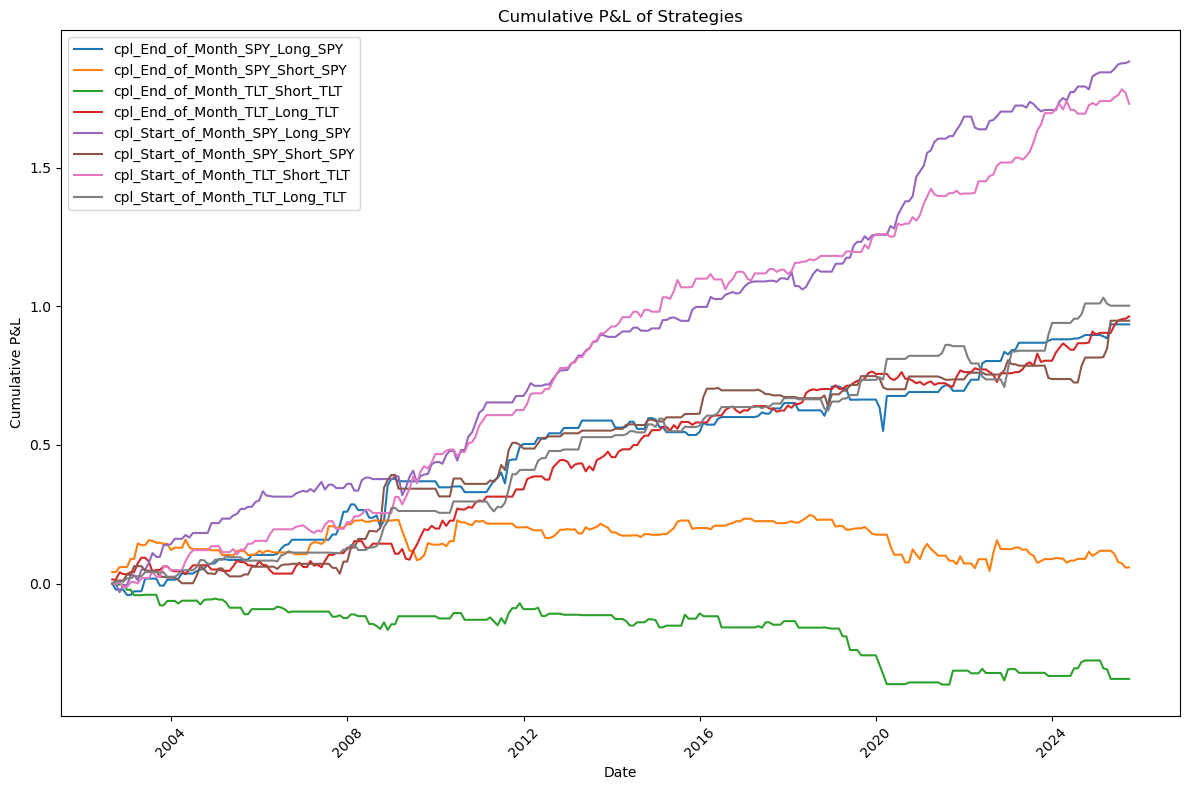

In [188]:
# plot all strategies cumulative PL using matplotlib with proper dates
plt.figure(figsize=(12, 8))
for col in strategy_columns:
    plt.plot(monthly_backtest_data['ym'], monthly_backtest_data[col], label=col)

plt.title('Cumulative P&L of Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [189]:
# add combined strategy cumulative PL (Total PL) column
"""
monthly_backtest_data.Total_PL row 0 = sum of 
    'End_of_Month_SPY_Long_SPY',
    'End_of_Month_SPY_Short_SPY',
    'End_of_Month_TLT_Short_TLT',
    'End_of_Month_TLT_Long_TLT',
    'Start_of_Month_SPY_Long_SPY',
    'Start_of_Month_SPY_Short_SPY',
    'Start_of_Month_TLT_Short_TLT',
    'Start_of_Month_TLT_Long_TLT'

monthly_backtest_data.Total_PL row n = previous row n-1 + sum of
    'End_of_Month_SPY_Long_SPY',
    'End_of_Month_SPY_Short_SPY',
    'End_of_Month_TLT_Short_TLT',
    'End_of_Month_TLT_Long_TLT',
    'Start_of_Month_SPY_Long_SPY',
    'Start_of_Month_SPY_Short_SPY',
    'Start_of_Month_TLT_Short_TLT',
    'Start_of_Month_TLT_Long_TLT'
for row n
"""
monthly_backtest_data['Total_PL'] = monthly_backtest_data[
    [
        'End_of_Month_SPY_Long_SPY',
        'End_of_Month_SPY_Short_SPY',
        'End_of_Month_TLT_Short_TLT',
        'End_of_Month_TLT_Long_TLT',
        'Start_of_Month_SPY_Long_SPY',
        'Start_of_Month_SPY_Short_SPY',
        'Start_of_Month_TLT_Short_TLT',
        'Start_of_Month_TLT_Long_TLT'
    ]
].sum(axis=1).cumsum()

In [190]:
# add SPY_Return column as cumulative sum of SPY_ret
monthly_backtest_data['SPY_Return'] = monthly_backtest_data['SPY_ret'].cumsum()

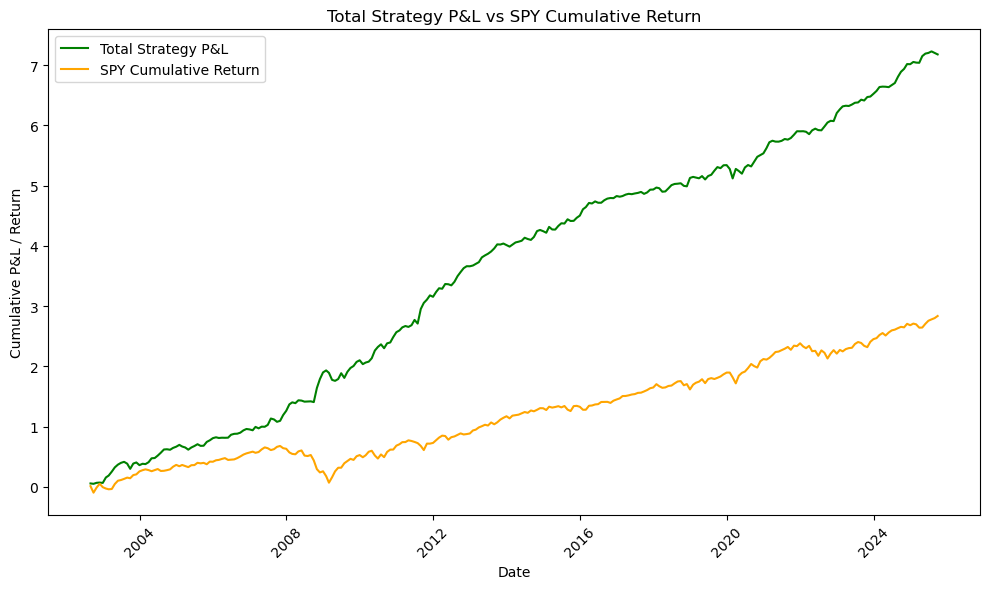

In [191]:
# plot Total_PL vs SPY_Return
plt.figure(figsize=(10, 6))
plt.plot(monthly_backtest_data['ym'], monthly_backtest_data['Total_PL'], label='Total Strategy P&L', color='green')
plt.plot(monthly_backtest_data['ym'], monthly_backtest_data['SPY_Return'], label='SPY Cumulative Return', color='orange')
plt.title('Total Strategy P&L vs SPY Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L / Return')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [192]:
# download to excel
monthly_backtest_data.to_excel('backtest_monthly_data_v2.xlsx', index=False)